### Load Modules

In [1]:
# path variables
import sys
project_path = '/Users/naresh/Downloads/ds_models/onboarding_fraud_model_v2/'
sys.path.insert(0, project_path+'config')
from config import SQLQuery

# core libraries
import pickle
import warnings
warnings.filterwarnings("ignore")
import datetime
import pandas as pd
import numpy as np
import textstat
import nltk
import json
import re
import validators
import requests

from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
from model_evaluations import model_metrics, cross_validation
from model_building import tune_hyperparameters
from sklearn.metrics import roc_curve, precision_recall_curve, precision_score, recall_score, roc_auc_score
from matplotlib import pyplot
from collections import Counter
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from fuzzywuzzy import fuzz
from itertools import permutations


WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


Custom DS Modules

In [2]:
%load_ext autoreload
%autoreload 2
from stability_monitoring import *

### Load the Dataset

In [3]:
df = pd.read_pickle(project_path+'data/pre_split_engg_data.pkl')

In [5]:
num_features = ['person_fraud_score', 'person_kyc_score', 'sentilink_abuse_score', 'sentilink_first_party_synthetic_score'
            ,'sentilink_third_party_synthetic_score', 'sentilink_id_theft_score', 'socure_sigma', 'socure_emailrisk', 'socure_phonerisk'
            ,'socure_addressrisk','number_of_employees']
num_features2 = ['business_address_zip', 'phone']
bool_features = ['ein_ssn','has_international_business']
cat_features = ['iovation_device_type', 'estimated_monthly_revenue', 'incoming_ach_payments', 'check_deposit_amount'
               , 'incoming_wire_transfer', 'outgoing_ach_and_checks', 'outgoing_wire_transfers', 'line_type', 'industry_category_name']
list_features = ['person_fraud_tags', 'person_kyc_tags', 'socure_reason_code', 'socure_kyc_field_validations'
                ,'socure_kyc_reason_code', 'socure_emailrisk_reason_code', 'socure_phonerisk_reason_code'
                ,'socure_addressrisk_reason_code', 'purpose_of_account', 'touch_point_emails', 'owner_list']
high_cardinality_features = ['iovation_device_timezone', 'iovation_device_ip', 'iovation_device_ip_isp', 'iovation_device_ip_org' 
                            ,'iovation_device_ip_city', 'iovation_device_ip_region', 'carrier', 'email', 'email_domain', 'industry_name'
                            , 'website', 'business_address_city', 'business_address_state', 'industry_category_from_pitch'
                            , 'company_name']
text_features = ['business_pitch']
id_features = ['application_id', 'business_id', 'train_flag', 'test_flag', 'target']
datetime_features = ['application_start_datetime', 'application_complete_datetime', 'application_resubmitted_datetime']



skip_list = num_features2+['line_type','iovation_device_ip','iovation_device_ip_city','iovation_device_ip_region','email',
                           'industry_name','website','business_address_city','business_address_state','industry_category_from_pitch',
                           'company_name','person_fraud_tags','person_kyc_tags','socure_reason_code','socure_kyc_field_validations',
                           'socure_kyc_reason_code','socure_emailrisk_reason_code','socure_phonerisk_reason_code',
                           'socure_addressrisk_reason_code','purpose_of_account','touch_point_emails','owner_list'
                          ]+id_features+datetime_features+text_features+['pos_counts','owner_name','text_standard']

#### Independent variables

In [6]:
# App features
independent_features = set(df.columns.to_list()) - set(skip_list)

In [7]:
data_type_dict = df.dtypes.astype(str).to_dict()
data_type_mapping = {'float64':np.float64,'object':object,'bool':bool,'Int64':np.int64}
data_type_dict = {k: data_type_mapping[v] for k, v in data_type_dict.items() if v in data_type_mapping}

df = df.astype(data_type_dict)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29471 entries, 0 to 29470
Columns: 338 entries, person_fraud_score to owner_name_email_match_flag
dtypes: bool(2), datetime64[ns, UTC](2), float64(56), int64(240), object(38)
memory usage: 75.8+ MB


### Train Data

In [9]:
x_train = df[df['train_flag'] == 1].reset_index(drop=True)
y_train = x_train['target']

In [10]:
# Removing reason code features as these are already encoded
x_train.drop(columns=skip_list, inplace=True)

# Encoding the categorical features
x_object_cols = x_train.select_dtypes(include=['object']).columns.to_list()
x_object_onehot = pd.get_dummies(x_train[x_object_cols]) # create dummies
x_object_onehot = x_object_onehot.astype('int')
x_train = pd.concat([x_train.drop(columns=x_object_cols), x_object_onehot], axis=1)
x_train.columns = x_train.columns.str.lower() # convert column names to lower case


In [11]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20629 entries, 0 to 20628
Columns: 328 entries, person_fraud_score to text_standard_levels_l3
dtypes: bool(2), float64(51), int64(275)
memory usage: 51.3 MB


In [12]:
# Save the train data features to use later in the test and oot data preparation
x_train = x_train[x_train.columns]
pd.DataFrame(x_train.columns.to_list(), columns=['feature']).to_pickle(project_path+'models/train_data_columns.pkl')
x_train.shape

(20629, 328)

### Test data

In [13]:
x_test = df[df['test_flag'] == 1].reset_index(drop=True)
y_test = x_test['target']

#### Feature creation

In [14]:
x_test.shape, y_test.shape

((8842, 338), (8842,))

In [15]:
# Removing reason code features as these are already encoded
x_test.drop(columns=skip_list, inplace=True)

# Encoding the categorical features
x_object_cols = x_test.select_dtypes(include=['object']).columns.to_list()
x_object_onehot = pd.get_dummies(x_test[x_object_cols]) # create dummies
x_object_onehot = x_object_onehot.astype('int')
x_test = pd.concat([x_test.drop(columns=x_object_cols), x_object_onehot], axis=1)
x_test.columns = x_test.columns.str.lower() # convert column names to lower case


In [16]:
# Filter only the final independent features used in the training data
train_cols = pd.read_pickle(project_path+'models/train_data_columns.pkl')['feature'].to_list()
df_tmp = pd.DataFrame(index=range(x_test.shape[0]),columns=train_cols)
df_tmp = df_tmp.fillna(0) # creating a dummy df using the columns from train dataset
df_tmp.update(x_test) # update the dummy df with test df values
x_test = df_tmp.copy()
x_test.shape

(8842, 328)

### OOT Data

In [17]:
# oot_df = pd.read_pickle(project_path+'data/nsl_oot_dataset_2023-05-30.pkl')
# y_oot = oot_df['ns_flag']

# # Adding segment test data
# segment_oot = pd.read_pickle(project_path+'data/segment_processed_data_oot.pkl')
# oot_df = pd.merge(oot_df, segment_oot, on='application_id', how='inner')
# x_oot = oot_df[raw_features]

In [18]:
# for col in string_features:
#     x_oot[col] = x_oot[col].str.lower()

In [19]:
# x_oot.shape, y_oot.shape

In [20]:
# x_oot = convert_nulls_to_one_format(df=x_oot)
# x_oot = fill_null_values(df_impute_apps, x_oot)
# x_oot = fill_null_values(df_impute, x_oot)

# x_oot = feature_engineering_app(df=x_oot)
# x_oot = feature_engineering_alloy(df=x_oot, training=False)

# # Removing reason code features as these are already encoded
# x_oot.drop(columns=ida_reason_cols+socure_reason_cols, inplace=True)

# # Encoding the categorical feataures
# x_object_cols = x_oot[independent_features_alloy_tmp].select_dtypes(include=['object']).columns.to_list()
# x_object_cols = x_object_cols+['industry_category_name']

# x_object_onehot = pd.get_dummies(x_oot[x_object_cols]) # create dummies
# x_object_onehot = x_object_onehot.astype('int')
# x_oot = pd.concat([x_oot.drop(columns=x_object_cols), x_object_onehot], axis=1)
# x_oot.columns= x_oot.columns.str.lower() # convert column names to lower case

In [21]:
# # Filter only the final independent features used in the training data
# train_cols = pd.read_pickle(project_path+'models/train_data_columns.pkl')['feature'].to_list()
# df_tmp = pd.DataFrame(index=range(x_oot.shape[0]),columns=train_cols)
# df_tmp = df_tmp.fillna(0)
# df_tmp.update(x_oot)
# x_oot = df_tmp.copy()
# x_oot.shape

### Model Training

In [22]:
# Class imbalance
y_train[y_train==0].shape[0]/y_train.sum()

25.966013071895425

#### Initial Model Fit to find the best features: Intuition and reasonable values
First approach is to start with reasonable parameters instead of the default xgboost model

In [23]:
tuned_model = XGBClassifier(max_depth=4, colsample_bytree=1 ,subsample=1 ,scale_pos_weight=18 ,learning_rate=0.1 
                            ,random_state=3)
tuned_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=3, ...)

TRAIN RESULTS:

Accuracy Score: 0.87 

Confusion Matrix:
        pred:1  pred:0
true:1     672      93
true:0    2562   17302 

False Positive Rate: 0.13
True Positive Rate: 0.88
AUC: 0.87 

Sensitivity: 0.88
Specificity: 0.87 

F1 Score: 0.34 

KS Score:
KstestResult(statistic=0.11968587910223472, pvalue=3.3699435895406496e-129, statistic_location=0.0, statistic_sign=-1) 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.87      0.93     19864
         1.0       0.21      0.88      0.34       765

    accuracy                           0.87     20629
   macro avg       0.60      0.87      0.63     20629
weighted avg       0.97      0.87      0.91     20629

Gain Chart


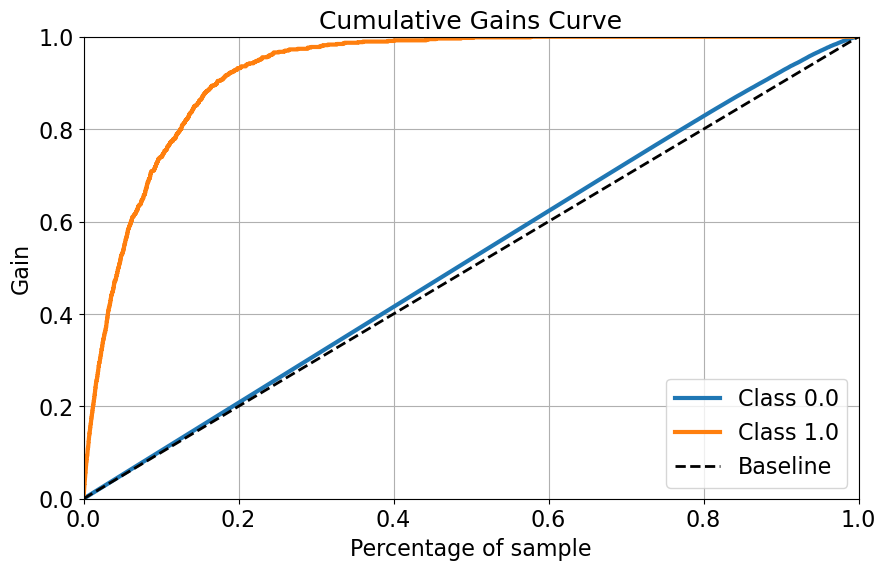

Lift Chart


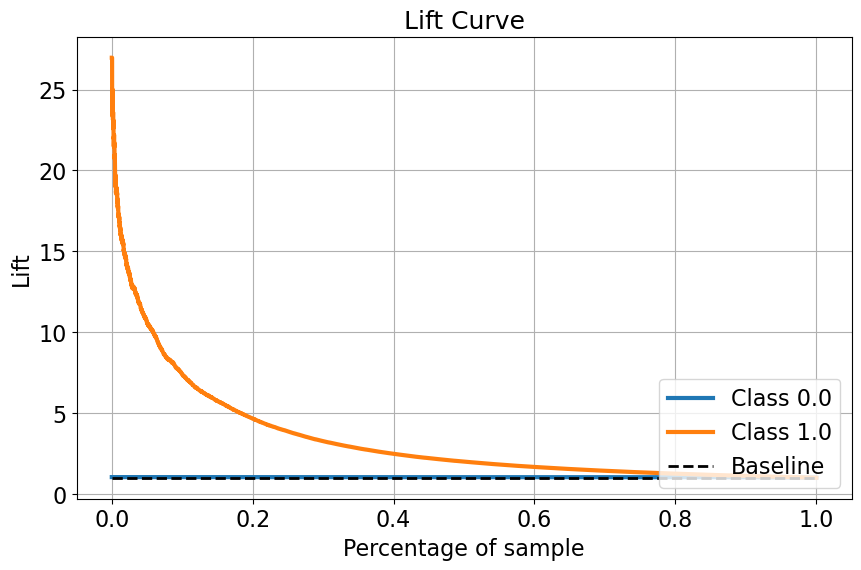



TEST RESULTS:

Accuracy Score: 0.84 

Confusion Matrix:
        pred:1  pred:0
true:1     137     191
true:0    1182    7332 

False Positive Rate: 0.14
True Positive Rate: 0.42
AUC: 0.64 

Sensitivity: 0.42
Specificity: 0.86 

F1 Score: 0.17 

KS Score:
KstestResult(statistic=0.11207871522280027, pvalue=9.22961276287964e-49, statistic_location=0.0, statistic_sign=-1) 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.86      0.91      8514
         1.0       0.10      0.42      0.17       328

    accuracy                           0.84      8842
   macro avg       0.54      0.64      0.54      8842
weighted avg       0.94      0.84      0.89      8842

Gain Chart


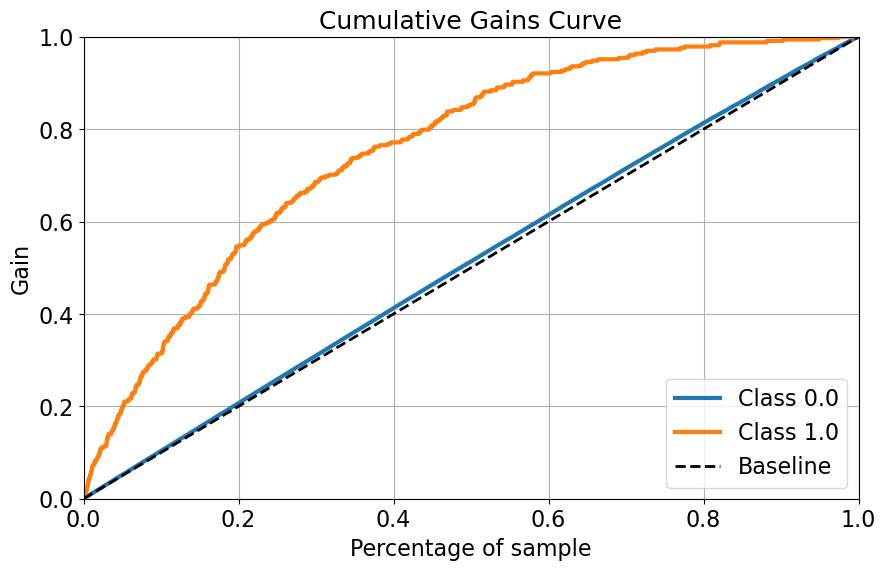

Lift Chart


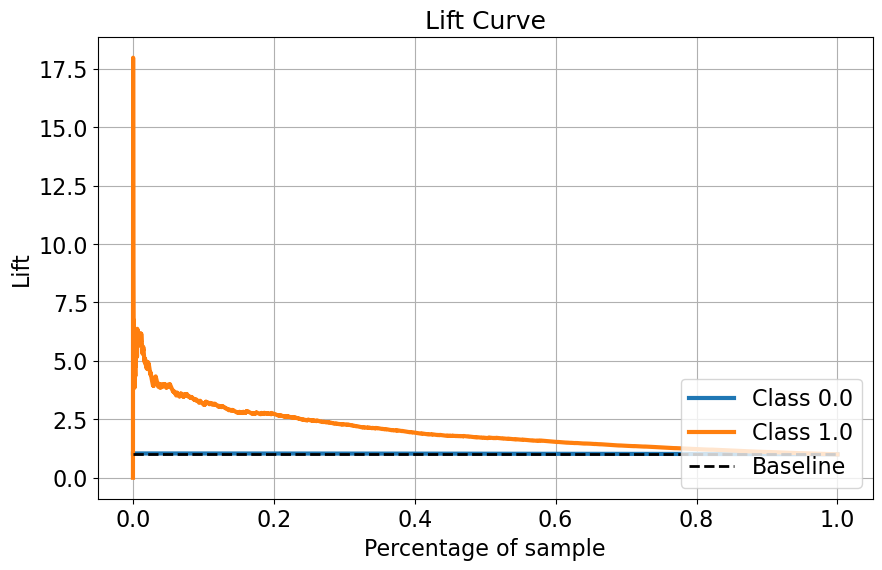

In [24]:
# Prediction on the train, test & oot datasets
print("TRAIN RESULTS:\n")
y_pred = tuned_model.predict(x_train)
predicted_probas = tuned_model.predict_proba(x_train)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = tuned_model.predict(x_test)
predicted_probas = tuned_model.predict_proba(x_test)
model_metrics(y_pred, y_test, predicted_probas)

# print("\n\nOOT RESULTS:\n")
# y_pred = tuned_model.predict(x_oot)
# predicted_probas = tuned_model.predict_proba(x_oot)
# model_metrics(y_pred, y_oot, predicted_probas)

#### Feature Importance

In [25]:
feature_imp_df = pd.DataFrame(zip(x_train.columns.to_list(), tuned_model.feature_importances_), columns=['feature','importance'])
feature_imp_df = feature_imp_df.sort_values(by=['importance'], ascending=False).reset_index(drop=True)
feature_imp_df[feature_imp_df.importance>=0.005]


feature  importance
0       socure_emailrisk_reason_code_i556    0.055997
1       socure_emailrisk_reason_code_r566    0.031613
2            iovation_device_type_android    0.018682
3                 outgoing_wire_transfers    0.017860
4       socure_emailrisk_reason_code_i555    0.017045
..                                    ...         ...
82                                     jj    0.005050
83  sentilink_third_party_synthetic_score    0.005036
84                 app_complete_dayofweek    0.005015
85          companyname_email_fuzzy_match    0.005009
86                             smog_index    0.005004

[87 rows x 2 columns]

In [26]:
feature_imp_df[:50]

feature  importance
0   socure_emailrisk_reason_code_i556    0.055997
1   socure_emailrisk_reason_code_r566    0.031613
2        iovation_device_type_android    0.018682
3             outgoing_wire_transfers    0.017860
4   socure_emailrisk_reason_code_i555    0.017045
5                             ein_ssn    0.015965
6                        socure_sigma    0.015402
7              incoming_wire_transfer    0.015132
8                    total_word_count    0.013673
9   socure_emailrisk_reason_code_i553    0.013629
10                   socure_phonerisk    0.013479
11                 email_domain_other    0.012679
12       iovation_device_type_windows    0.012493
13            outgoing_ach_and_checks    0.012268
14             person_fraud_tags_flag    0.012056
15      socure_kyc_mobilenumber_score    0.011852
16          estimated_monthly_revenue    0.011849
17        industry_category_name_cat1    0.011616
18            socure_reason_code_r208    0.011551
19  socure_emailrisk_reason_code_i568    0.010369
20  socure_emailrisk_reason_code_r560    0.009831
21               check_deposit_amount    0.009522
22  socure_phonerisk_reason_code_i618    0.009343
23  socure_phonerisk_reason_code_r637    0.009229
24              incoming_ach_payments    0.009212
25  socure_phonerisk_reason_code_r632    0.009066
26     iovation_device_ip_isp_tmobile    0.008897
27                number_of_employees    0.008479
28                     syllable_count    0.008355
29  socure_phonerisk_reason_code_i616    0.008200
30  socure_phonerisk_reason_code_r617    0.008048
31                 person_fraud_score    0.008023
32  socure_emailrisk_reason_code_i566    0.007808
33            socure_reason_code_r210    0.007582
34                         ip_class_a    0.007516
35                app_start_dayofweek    0.007427
36     iovation_device_ip_isp_charter    0.007329
37     iovation_device_ip_org_charter    0.007125
38  socure_phonerisk_reason_code_r658    0.007093
39                   socure_emailrisk    0.006995
40                 coleman_liau_index    0.006993
41  socure_phonerisk_reason_code_i620    0.006731
42                     sentence_count    0.006615
43                                 nn    0.006602
44           app_complete_dateofmonth    0.006568
45        automated_readability_index    0.006526
46             app_complete_hourofday    0.006481
47                flesch_reading_ease    0.006447
48                    email_domain_l2    0.006382
49     iovation_device_ip_org_verizon    0.006275

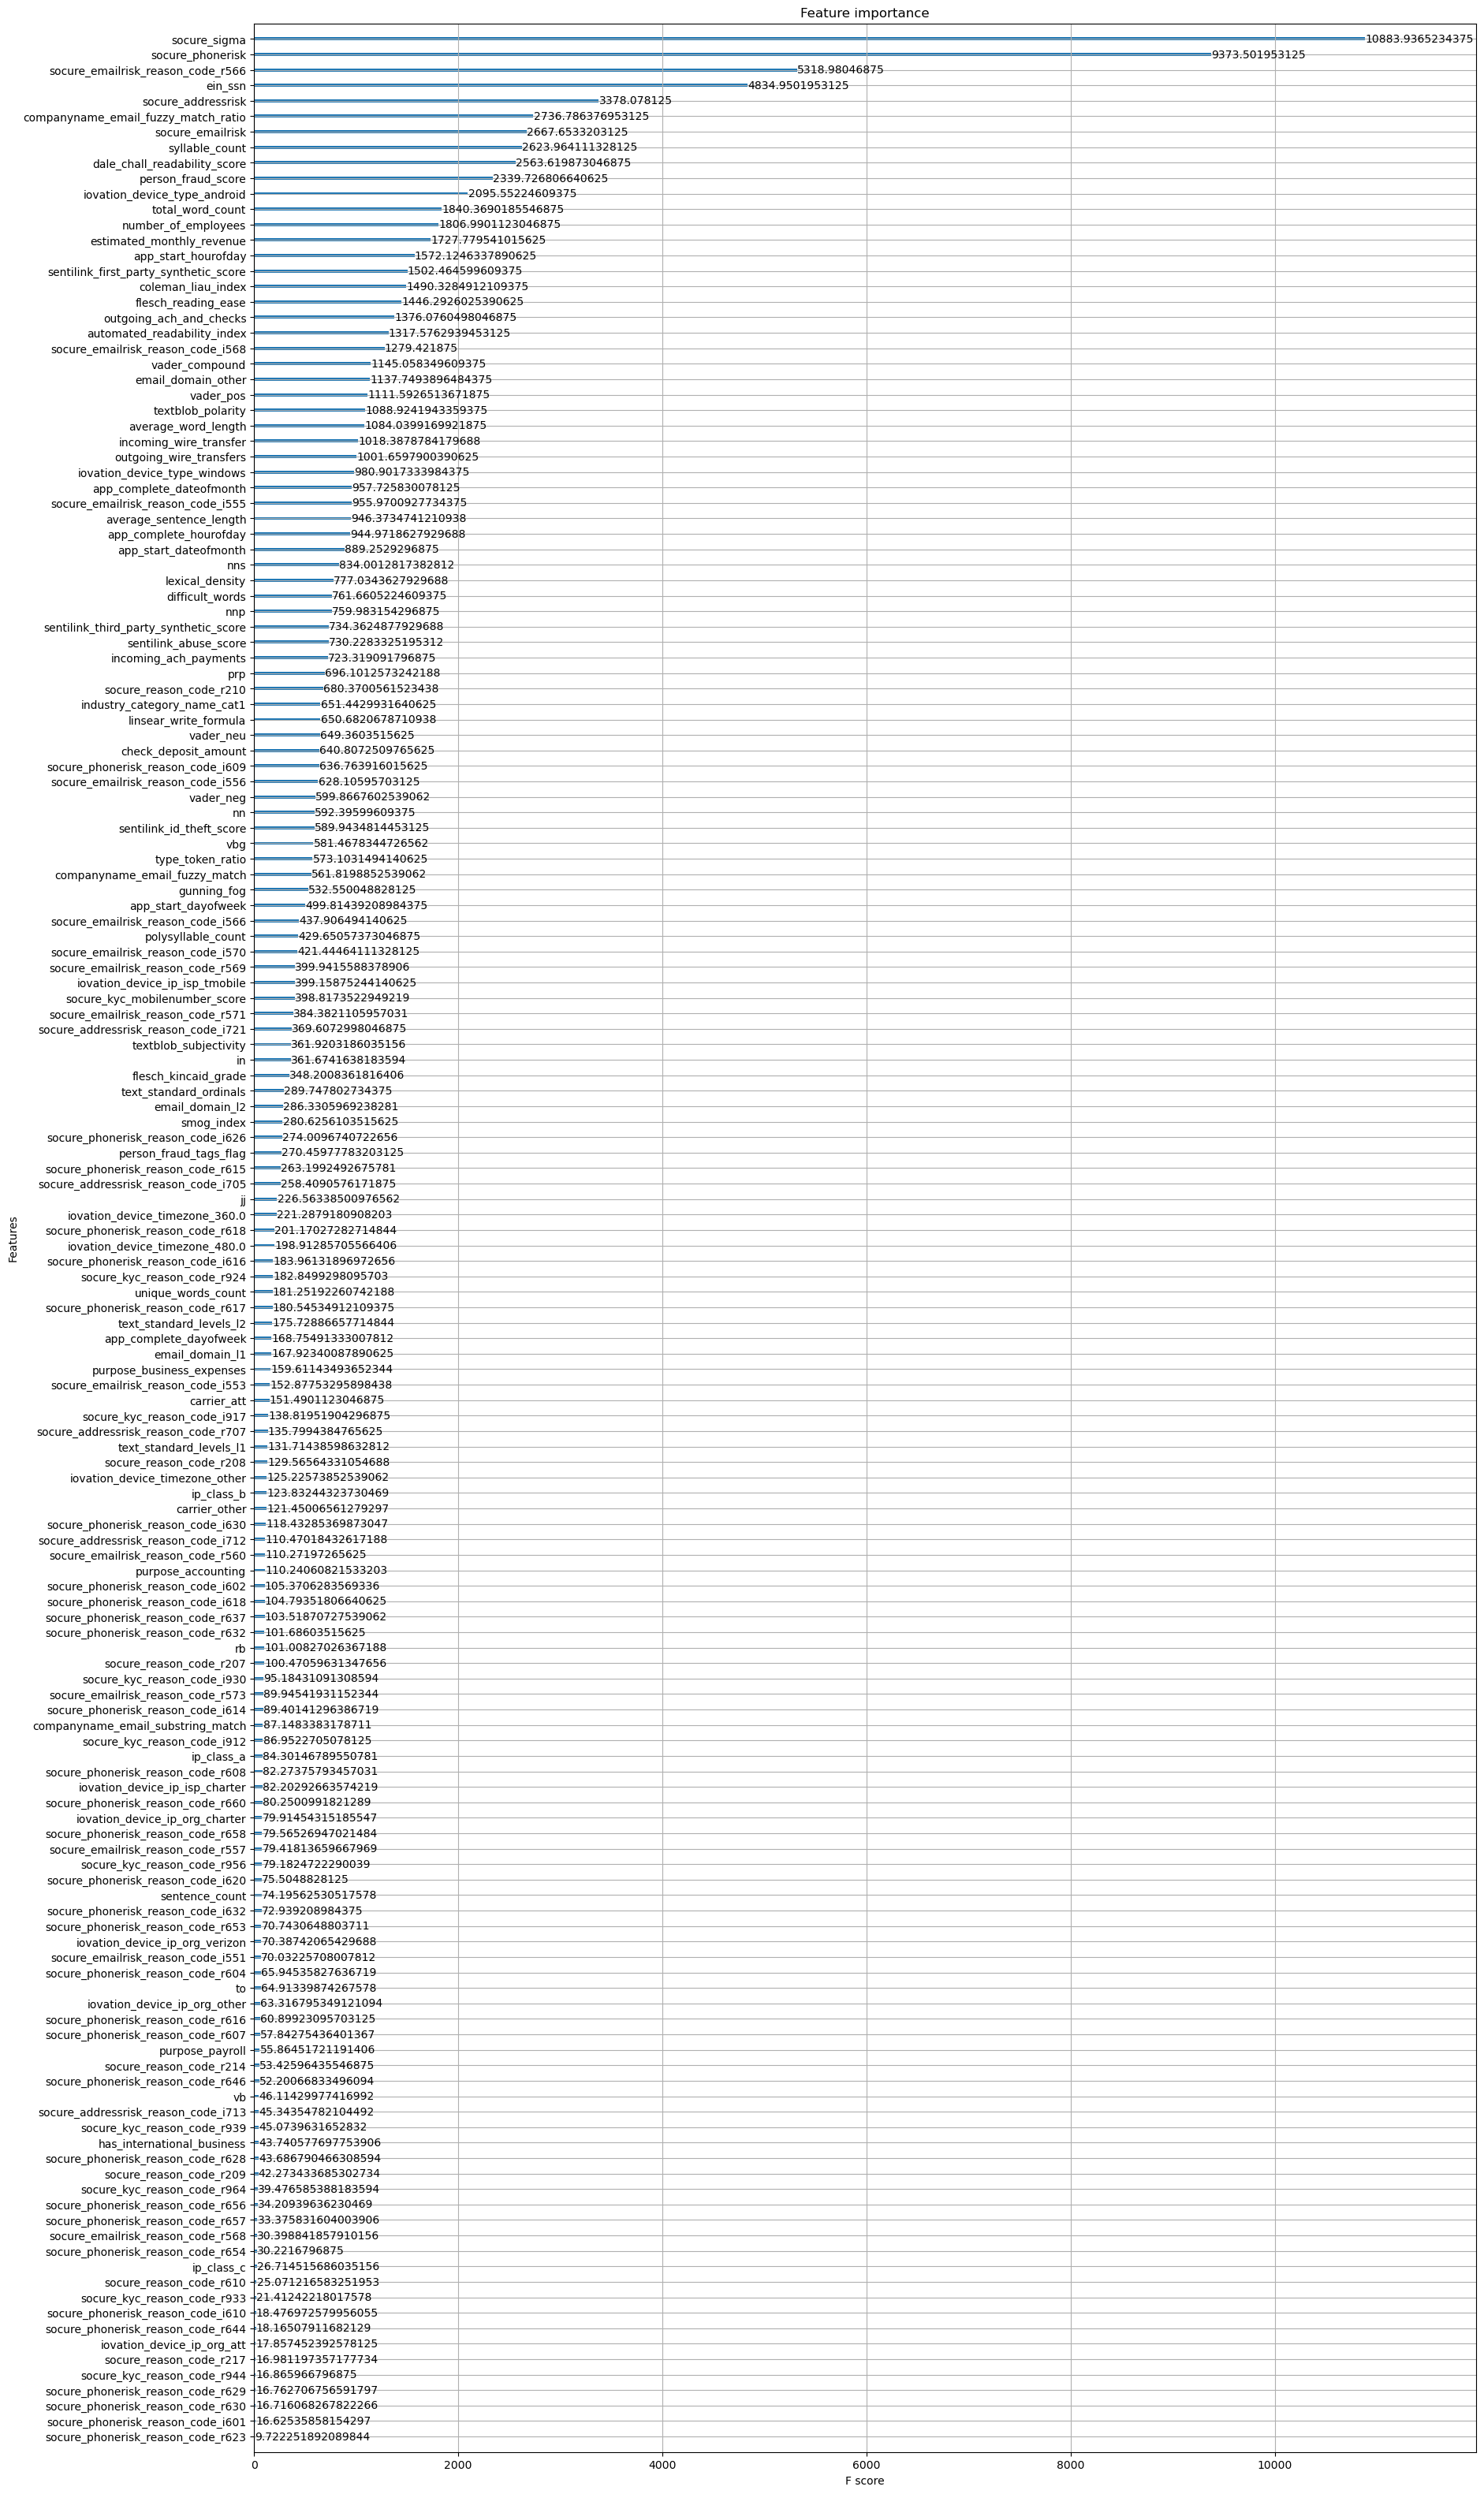

In [29]:
plt.rcParams["figure.figsize"] = (20,40)
plot_importance(tuned_model, importance_type='total_gain')
plt.show()

#### Train rank ordering

In [30]:
# train
x_train.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)

df_train = x_train.copy()
df_train['ns_flag'] = y_train
df_train['proba'] = tuned_model.predict_proba(x_train)[:,1:].flatten()

# custom_bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
custom_bins = [0.0, 0.2, 0.4, 0.6, 1.0]
df_train['proba'] = np.round(df_train['proba'], 3)
df_train['DecileRank']= pd.cut(df_train['proba'], bins=custom_bins)
df_stats = pd.DataFrame(df_train.groupby(by='DecileRank')['ns_flag'].mean())
df_stats['volume'] = df_train.groupby(by='DecileRank')['ns_flag'].count()
df_stats['volume%'] = np.round((df_stats['volume'] / df_stats['volume'].sum())*100, 2)
df_stats

ns_flag  volume  volume%
DecileRank                           
(0.0, 0.2]  0.000100   10027    48.61
(0.2, 0.4]  0.004453    5390    26.13
(0.4, 0.6]  0.063926    3551    17.21
(0.6, 1.0]  0.308850    1661     8.05

#### Test rank ordering

In [31]:
# test
x_test.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

df_test = x_test.copy()
df_test['ns_flag'] = y_test
df_test['proba'] = tuned_model.predict_proba(x_test)[:,1:].flatten()

df_test['proba'] = np.round(df_test['proba'], 3)
df_test['DecileRank']= pd.cut(df_test['proba'], bins=custom_bins)
df_stats = pd.DataFrame(df_test.groupby(by='DecileRank')['ns_flag'].mean())
df_stats['volume'] = df_test.groupby(by='DecileRank')['ns_flag'].count()
df_stats['volume%'] = np.round((df_stats['volume'] / df_stats['volume'].sum())*100, 2)
df_stats

ns_flag  volume  volume%
DecileRank                           
(0.0, 0.2]  0.009172    4252    48.09
(0.2, 0.4]  0.036247    2345    26.52
(0.4, 0.6]  0.075436    1604    18.14
(0.6, 1.0]  0.129485     641     7.25

#### OOT rank ordering

In [32]:
# x_oot.reset_index(drop=True,inplace=True)
# y_oot.reset_index(drop=True,inplace=True)

# df_oot = x_oot.copy()
# df_oot['ns_flag'] = y_oot
# df_oot['proba'] = tuned_model.predict_proba(x_oot)[:,1:].flatten()

# df_oot['proba'] = np.round(df_oot['proba'], 3)
# df_oot['DecileRank']= pd.cut(df_oot['proba'], bins=custom_bins)
# df_stats = pd.DataFrame(df_oot.groupby(by='DecileRank')['ns_flag'].mean())
# df_stats['volume'] = df_oot.groupby(by='DecileRank')['ns_flag'].count()
# df_stats['volume%'] = np.round((df_stats['volume'] / df_stats['volume'].sum())*100, 2)
# df_stats

#### Hyperparameter tuning

In [44]:
estimator = XGBClassifier(random_state=3)

parameters = {
    'max_depth': range (2, 5, 1),
    'learning_rate': [0.05, 0.1, 0.15],
    'scale_pos_weight' : range(4, 8, 1)
}

x_train_test = pd.concat([x_train, x_test], axis=0).reset_index(drop=True)
y_train_test = np.concatenate([y_train, y_test], axis=0)

best_model = tune_hyperparameters(x_train_test, y_train_test, estimator, parameters, metric='roc_auc', cv_folds=3)


/Users/naresh/.pyenv/versions/3.9.2/envs/nsl_v2/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/naresh/.pyenv/versions/3.9.2/envs/nsl_v2/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/naresh/.pyenv/versions/3.9.2/envs/nsl_v2/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/naresh/.pyenv/versions/3.9.2/envs/nsl_v2/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pa

/Users/naresh/.pyenv/versions/3.9.2/envs/nsl_v2/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/naresh/.pyenv/versions/3.9.2/envs/nsl_v2/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/naresh/.pyenv/versions/3.9.2/envs/nsl_v2/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/naresh/.pyenv/versions/3.9.2/envs/nsl_v2/lib/pyt

/Users/naresh/.pyenv/versions/3.9.2/envs/nsl_v2/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/naresh/.pyenv/versions/3.9.2/envs/nsl_v2/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/naresh/.pyenv/versions/3.9.2/envs/nsl_v2/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/naresh/.pyenv/versions/3.9.2/envs/nsl_v2/lib/pyt

/Users/naresh/.pyenv/versions/3.9.2/envs/nsl_v2/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/naresh/.pyenv/versions/3.9.2/envs/nsl_v2/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/naresh/.pyenv/versions/3.9.2/envs/nsl_v2/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/naresh/.pyenv/versions/3.9.2/envs/nsl_v2/lib/pyt

/Users/naresh/.pyenv/versions/3.9.2/envs/nsl_v2/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/naresh/.pyenv/versions/3.9.2/envs/nsl_v2/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/naresh/.pyenv/versions/3.9.2/envs/nsl_v2/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/naresh/.pyenv/versions/3.9.2/envs/nsl_v2/lib/pyt

[18:31:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:56:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:59:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:08:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

In [45]:
best_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=3,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

TRAIN RESULTS:

Accuracy Score: 0.88 

Confusion Matrix:
        pred:0  pred:1
true:0   70930    6159
true:1    4073    3392 

False Positive Rate: 0.08
True Positive Rate: 0.45
AUC: 0.69 

Sensitivity: 0.45
Specificity: 0.92 

F1 Score: 0.4 

KS Score:
KstestResult(statistic=0.024670624689547616, pvalue=8.728021877400755e-23) 

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93     77089
           1       0.36      0.45      0.40      7465

    accuracy                           0.88     84554
   macro avg       0.65      0.69      0.67     84554
weighted avg       0.89      0.88      0.89     84554

Gain Chart


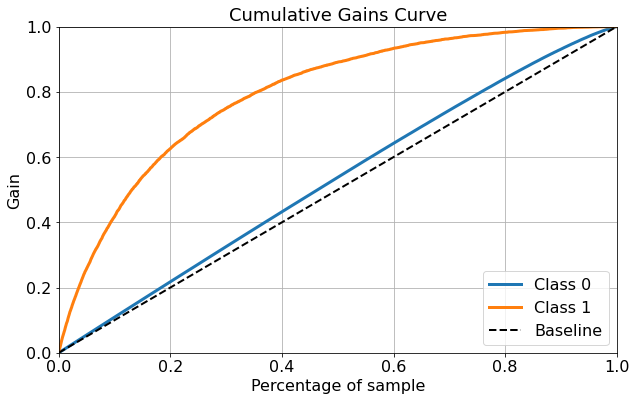

Lift Chart


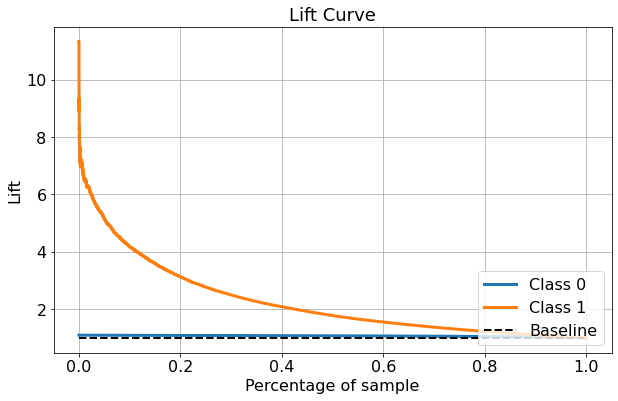



TEST RESULTS:

Accuracy Score: 0.88 

Confusion Matrix:
        pred:0  pred:1
true:0   31364    2847
true:1    1754    1446 

False Positive Rate: 0.08
True Positive Rate: 0.45
AUC: 0.68 

Sensitivity: 0.45
Specificity: 0.92 

F1 Score: 0.39 

KS Score:
KstestResult(statistic=0.029216005987543814, pvalue=2.6385439714223155e-14) 

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93     34211
           1       0.34      0.45      0.39      3200

    accuracy                           0.88     37411
   macro avg       0.64      0.68      0.66     37411
weighted avg       0.89      0.88      0.88     37411

Gain Chart


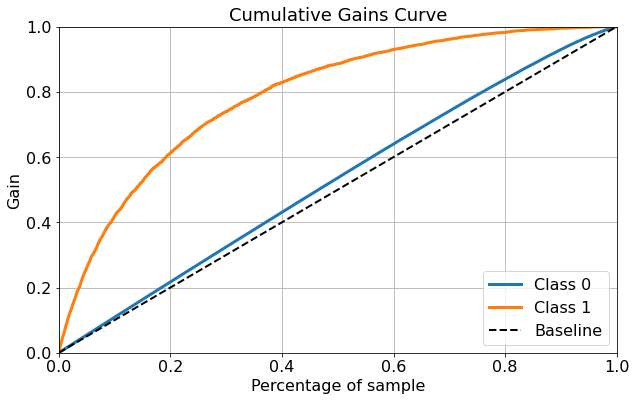

Lift Chart


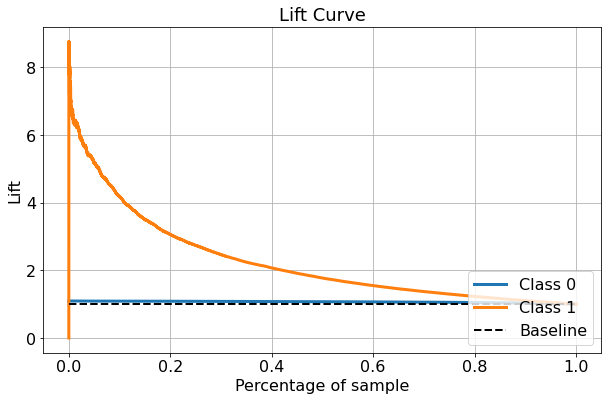



OOT RESULTS:

Accuracy Score: 0.9 

Confusion Matrix:
        pred:0  pred:1
true:0   22092    1545
true:1    1081     656 

False Positive Rate: 0.07
True Positive Rate: 0.38
AUC: 0.66 

Sensitivity: 0.38
Specificity: 0.93 

F1 Score: 0.33 

KS Score:
KstestResult(statistic=0.018286434933396434, pvalue=0.0004079227429908311) 

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94     23637
           1       0.30      0.38      0.33      1737

    accuracy                           0.90     25374
   macro avg       0.63      0.66      0.64     25374
weighted avg       0.91      0.90      0.90     25374

Gain Chart


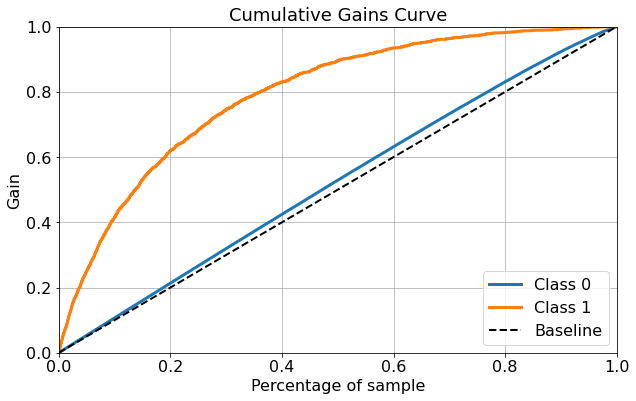

Lift Chart


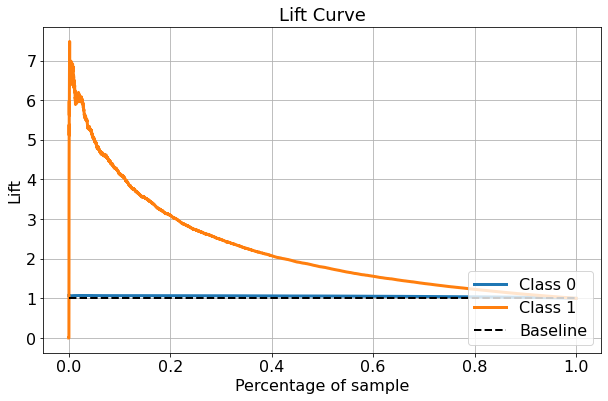

In [46]:
# Prediction on the train, test & oot datasets
print("TRAIN RESULTS:\n")
y_pred = best_model.predict(x_train)
predicted_probas = best_model.predict_proba(x_train)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = best_model.predict(x_test)
predicted_probas = best_model.predict_proba(x_test)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = best_model.predict(x_oot)
predicted_probas = best_model.predict_proba(x_oot)
model_metrics(y_pred, y_oot, predicted_probas)

[18:32:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN RESULTS:

Accuracy Score: 0.84 

Confusion Matrix:
        pred:0  pred:1
true:0   66486   10603
true:1    3034    4431 

False Positive Rate: 0.14
True Positive Rate: 0.59
AUC: 0.73 

Sensitivity: 0.59
Specificity: 0.86 

F1 Score: 0.39 

KS Score:
KstestResult(statistic=0.0895167585211818, pvalue=3.112523362430028e-295) 

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.86      0.91     77089
           1       0.29      0.59      0.39      7465

    accuracy                           0.84     84554
   macro avg       0.63      0.73      0.65     84554
weighted avg       0.90      0.84      0.86     84554

Gain Chart


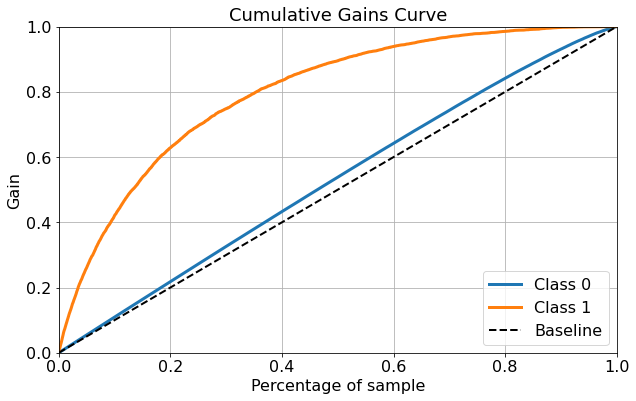

Lift Chart


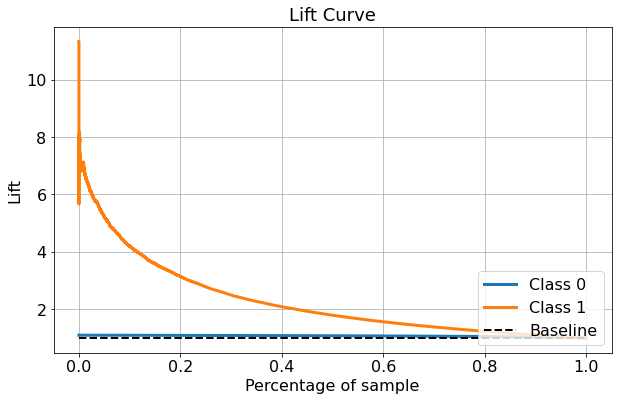



TEST RESULTS:

Accuracy Score: 0.83 

Confusion Matrix:
        pred:0  pred:1
true:0   29213    4998
true:1    1457    1743 

False Positive Rate: 0.15
True Positive Rate: 0.54
AUC: 0.7 

Sensitivity: 0.54
Specificity: 0.85 

F1 Score: 0.35 

KS Score:
KstestResult(statistic=0.09465130576568392, pvalue=2.6421055621209433e-146) 

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90     34211
           1       0.26      0.54      0.35      3200

    accuracy                           0.83     37411
   macro avg       0.61      0.70      0.63     37411
weighted avg       0.89      0.83      0.85     37411

Gain Chart


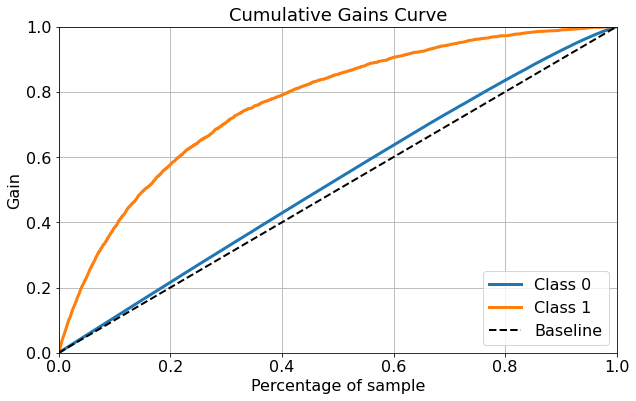

Lift Chart


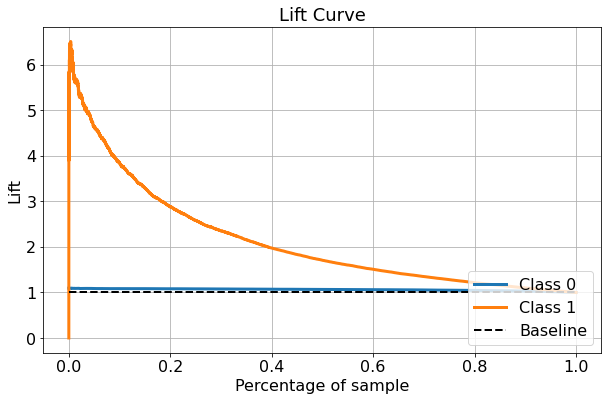



OOT RESULTS:

Accuracy Score: 0.86 

Confusion Matrix:
        pred:0  pred:1
true:0   20858    2779
true:1     854     883 

False Positive Rate: 0.12
True Positive Rate: 0.51
AUC: 0.7 

Sensitivity: 0.51
Specificity: 0.88 

F1 Score: 0.33 

KS Score:
KstestResult(statistic=0.07586505872152605, pvalue=5.947023132083396e-64) 

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92     23637
           1       0.24      0.51      0.33      1737

    accuracy                           0.86     25374
   macro avg       0.60      0.70      0.62     25374
weighted avg       0.91      0.86      0.88     25374

Gain Chart


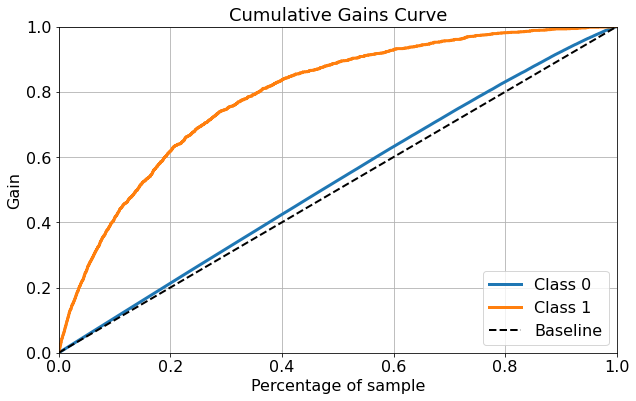

Lift Chart


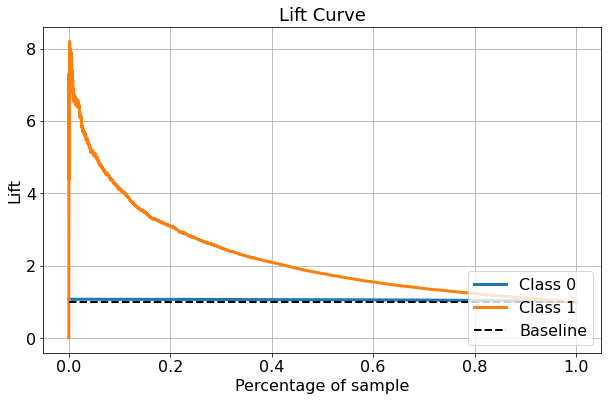

In [47]:
# Prediction on the train, test & oot datasets
best_model2 = XGBClassifier(random_state=3, max_depth=4, scale_pos_weight=6, learning_rate=0.1)
best_model2.fit(x_train, y_train)

print("TRAIN RESULTS:\n")
y_pred = best_model2.predict(x_train)
predicted_probas = best_model2.predict_proba(x_train)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = best_model2.predict(x_test)
predicted_probas = best_model2.predict_proba(x_test)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = best_model2.predict(x_oot)
predicted_probas = best_model2.predict_proba(x_oot)
model_metrics(y_pred, y_oot, predicted_probas)

[18:33:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN RESULTS:

Accuracy Score: 0.82 

Confusion Matrix:
        pred:0  pred:1
true:0   64263   12826
true:1    2685    4780 

False Positive Rate: 0.17
True Positive Rate: 0.64
AUC: 0.74 

Sensitivity: 0.64
Specificity: 0.83 

F1 Score: 0.38 

KS Score:
KstestResult(statistic=0.1199351893464532, pvalue=0.0) 

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.83      0.89     77089
           1       0.27      0.64      0.38      7465

    accuracy                           0.82     84554
   macro avg       0.62      0.74      0.64     84554
weighted avg       0.90      0.82      0.85     84554

Gain Chart


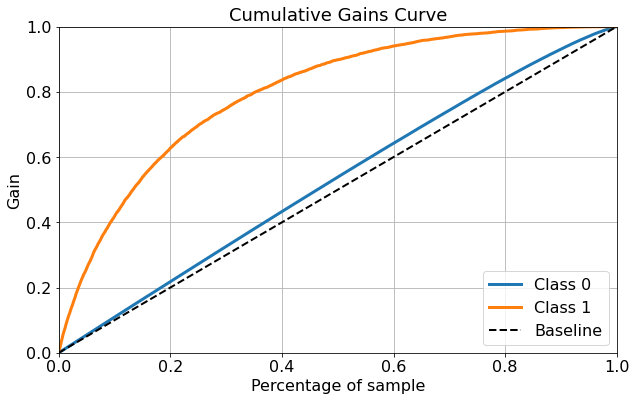

Lift Chart


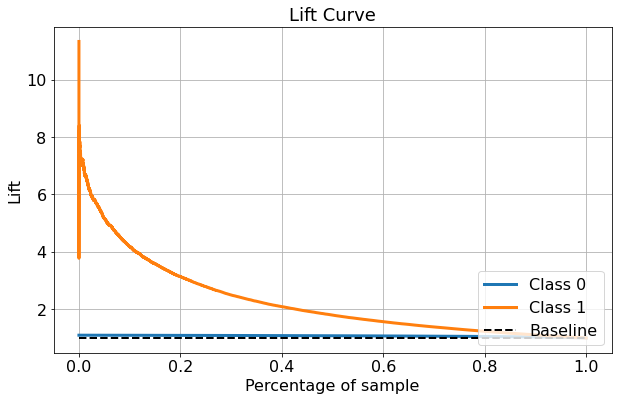



TEST RESULTS:

Accuracy Score: 0.8 

Confusion Matrix:
        pred:0  pred:1
true:0   28106    6105
true:1    1303    1897 

False Positive Rate: 0.18
True Positive Rate: 0.59
AUC: 0.71 

Sensitivity: 0.59
Specificity: 0.82 

F1 Score: 0.34 

KS Score:
KstestResult(statistic=0.12835796958113932, pvalue=3.825232768844863e-269) 

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.82      0.88     34211
           1       0.24      0.59      0.34      3200

    accuracy                           0.80     37411
   macro avg       0.60      0.71      0.61     37411
weighted avg       0.89      0.80      0.84     37411

Gain Chart


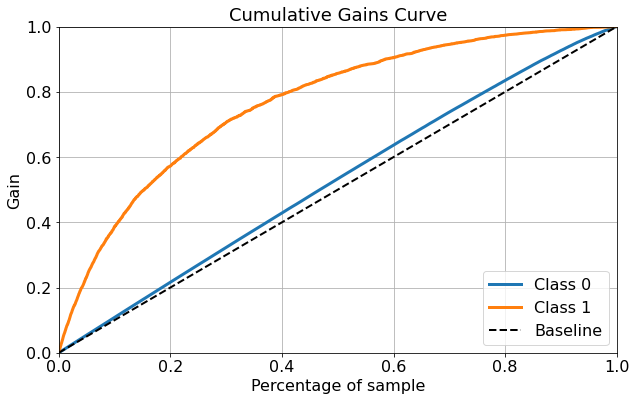

Lift Chart


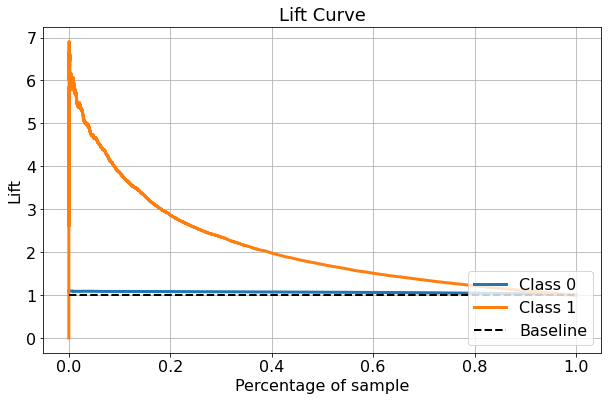



OOT RESULTS:

Accuracy Score: 0.84 

Confusion Matrix:
        pred:0  pred:1
true:0   20304    3333
true:1     771     966 

False Positive Rate: 0.14
True Positive Rate: 0.56
AUC: 0.71 

Sensitivity: 0.56
Specificity: 0.86 

F1 Score: 0.32 

KS Score:
KstestResult(statistic=0.10096949633483099, pvalue=4.707593295048182e-113) 

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.86      0.91     23637
           1       0.22      0.56      0.32      1737

    accuracy                           0.84     25374
   macro avg       0.59      0.71      0.61     25374
weighted avg       0.91      0.84      0.87     25374

Gain Chart


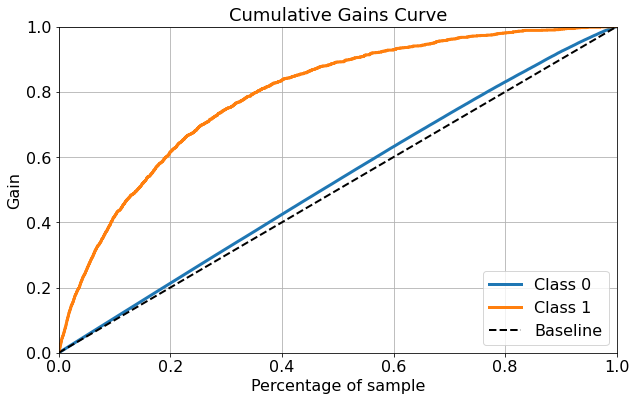

Lift Chart


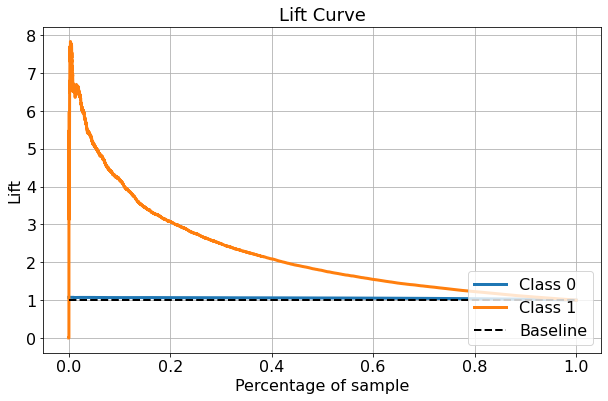

In [48]:
# Prediction on the train, test & oot datasets
best_model2 = XGBClassifier(random_state=3, max_depth=4, scale_pos_weight=7, learning_rate=0.1)
best_model2.fit(x_train, y_train)

print("TRAIN RESULTS:\n")
y_pred = best_model2.predict(x_train)
predicted_probas = best_model2.predict_proba(x_train)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = best_model2.predict(x_test)
predicted_probas = best_model2.predict_proba(x_test)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = best_model2.predict(x_oot)
predicted_probas = best_model2.predict_proba(x_oot)
model_metrics(y_pred, y_oot, predicted_probas)

[18:34:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:56:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:59:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:05:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

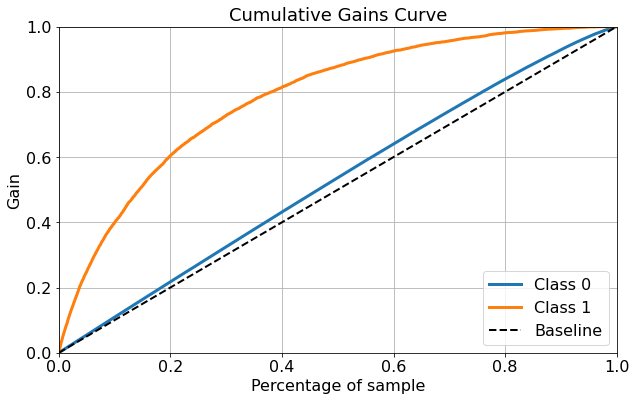

Lift Chart


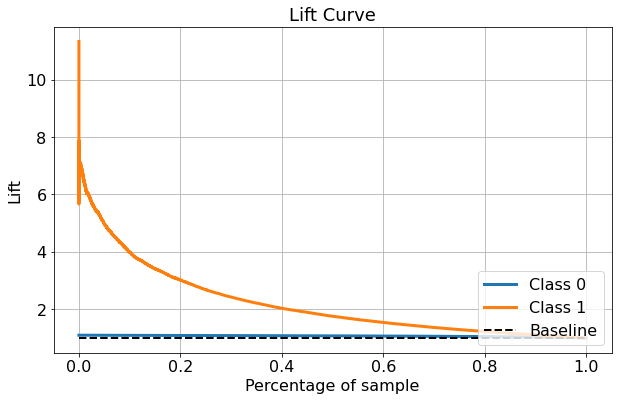



TEST RESULTS:

Accuracy Score: 0.8 

Confusion Matrix:
        pred:0  pred:1
true:0   28067    6144
true:1    1317    1883 

False Positive Rate: 0.18
True Positive Rate: 0.59
AUC: 0.7 

Sensitivity: 0.59
Specificity: 0.82 

F1 Score: 0.34 

KS Score:
KstestResult(statistic=0.12902622223410232, pvalue=5.8487079644425834e-272) 

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.82      0.88     34211
           1       0.23      0.59      0.34      3200

    accuracy                           0.80     37411
   macro avg       0.59      0.70      0.61     37411
weighted avg       0.89      0.80      0.84     37411

Gain Chart


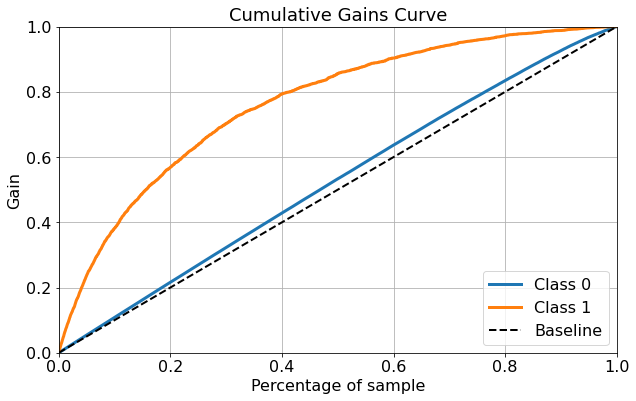

Lift Chart


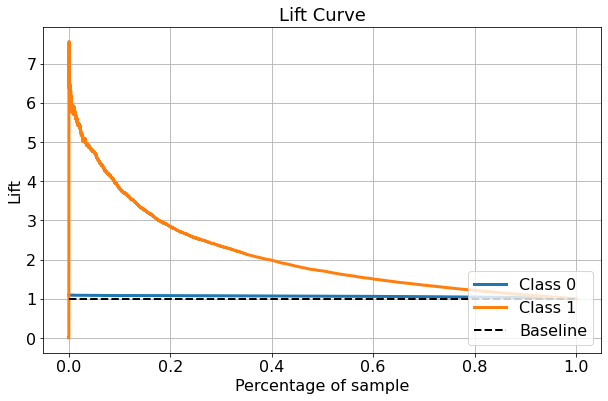



OOT RESULTS:

Accuracy Score: 0.83 

Confusion Matrix:
        pred:0  pred:1
true:0   20152    3485
true:1     741     996 

False Positive Rate: 0.15
True Positive Rate: 0.57
AUC: 0.71 

Sensitivity: 0.57
Specificity: 0.85 

F1 Score: 0.32 

KS Score:
KstestResult(statistic=0.1081421927957752, pvalue=1.1517529896641214e-129) 

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.85      0.91     23637
           1       0.22      0.57      0.32      1737

    accuracy                           0.83     25374
   macro avg       0.59      0.71      0.61     25374
weighted avg       0.91      0.83      0.87     25374

Gain Chart


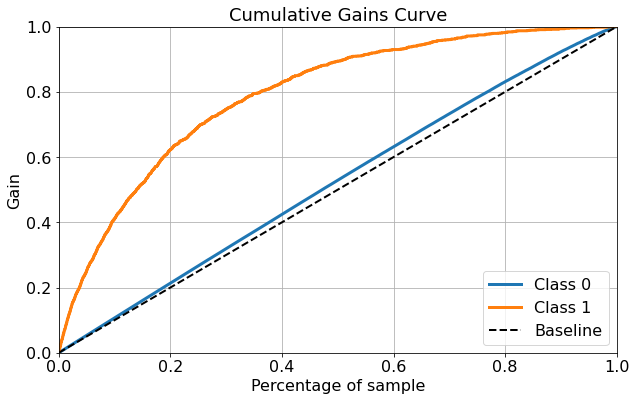

Lift Chart


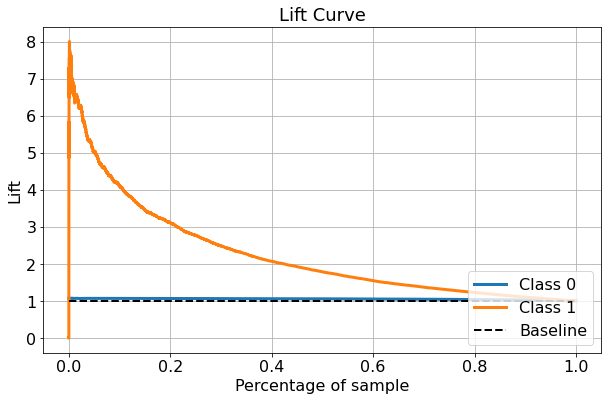

In [49]:
# Prediction on the train, test & oot datasets
best_model2 = XGBClassifier(random_state=3, max_depth=3, scale_pos_weight=7, learning_rate=0.1)
best_model2.fit(x_train, y_train)

print("TRAIN RESULTS:\n")
y_pred = best_model2.predict(x_train)
predicted_probas = best_model2.predict_proba(x_train)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = best_model2.predict(x_test)
predicted_probas = best_model2.predict_proba(x_test)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = best_model2.predict(x_oot)
predicted_probas = best_model2.predict_proba(x_oot)
model_metrics(y_pred, y_oot, predicted_probas)

#### Selecting the top features basis the model with depth:3 and weight:7, which is producing the better metrics: Precision, Recall & AUC.


In [50]:
feature_imp_df = pd.DataFrame(zip(x_train.columns.to_list(), best_model2.feature_importances_), columns=['feature','importance'])
feature_imp_df = feature_imp_df.sort_values(by=['importance'], ascending=False).reset_index(drop=True)
feature_imp_df[feature_imp_df.importance>=0.005]


feature  importance
0                           estimated_monthly_revenue    0.208325
1                               incoming_ach_payments    0.049911
2                                    sh_sw_ratio_mean    0.042793
3                                   screen_width_mean    0.034371
4   industry_category_name_professional, scientifi...    0.031985
5                                      business_group    0.030180
6                             outgoing_ach_and_checks    0.029390
7                                        socure_sigma    0.023627
8                            iovation_device_type_mac    0.022532
9   industry_category_name_real estate rental and ...    0.020590
10                                   socure_emailrisk    0.020392
11                  socure_emailrisk_reason_code_i566    0.018841
12                                   socure_phonerisk    0.017119
13                industry_category_name_retail trade    0.016810
14                  socure_emailrisk_reason_code_i553    0.015966
15                       iovation_device_type_android    0.014746
16                            outgoing_wire_transfers    0.013228
17                  socure_emailrisk_reason_code_r561    0.012832
18                               check_deposit_amount    0.012750
19                  socure_phonerisk_reason_code_i630    0.012350
20                            socure_reason_code_r207    0.012065
21                  socure_phonerisk_reason_code_i614    0.010442
22                       iovation_device_timezone_480    0.009072
23                                   line_type_mobile    0.008003
24                                 screen_height_mean    0.007961
25                            socure_reason_code_i127    0.007617
26                                         page_count    0.007190
27  industry_category_name_administrative and supp...    0.006963
28                  socure_phonerisk_reason_code_r616    0.006961
29               industry_category_name_manufacturing    0.006786
30                                email_domain_bucket    0.006773
31                             incoming_wire_transfer    0.006551
32  industry_category_name_health care and social ...    0.006547
33                  socure_phonerisk_reason_code_r639    0.006310
34                            socure_reason_code_i121    0.006247
35                             ida_score_reason_2_946    0.006193
36                                    carrier_tmobile    0.005950
37                  socure_phonerisk_reason_code_r608    0.005815
38              industry_category_name_other services    0.005783
39                                   verify-email-otp    0.005720
40                                      carrier_other    0.005549
41                             ida_score_reason_1_641    0.005219
42                     iovation_device_timezone_other    0.005188
43                           app/applicant/otp-verify    0.005128
44                       iovation_device_timezone_300    0.005068

In [51]:
top_features_41 = feature_imp_df[:41]['feature'].to_list()

[18:40:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN RESULTS:

Accuracy Score: 0.81 

Confusion Matrix:
        pred:0  pred:1
true:0   63625   13464
true:1    2837    4628 

False Positive Rate: 0.17
True Positive Rate: 0.62
AUC: 0.72 

Sensitivity: 0.62
Specificity: 0.83 

F1 Score: 0.36 

KS Score:
KstestResult(statistic=0.1256829954821771, pvalue=0.0) 

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.83      0.89     77089
           1       0.26      0.62      0.36      7465

    accuracy                           0.81     84554
   macro avg       0.61      0.72      0.62     84554
weighted avg       0.90      0.81      0.84     84554

Gain Chart


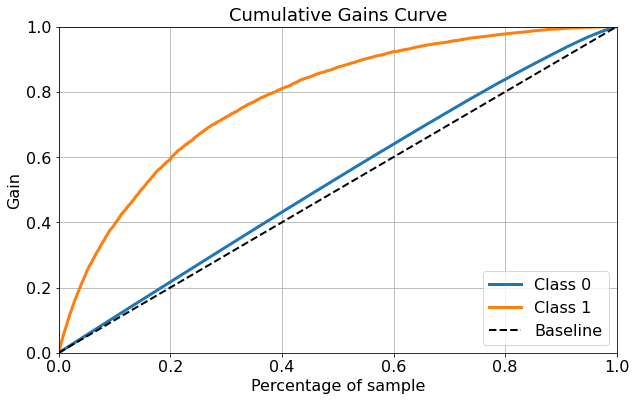

Lift Chart


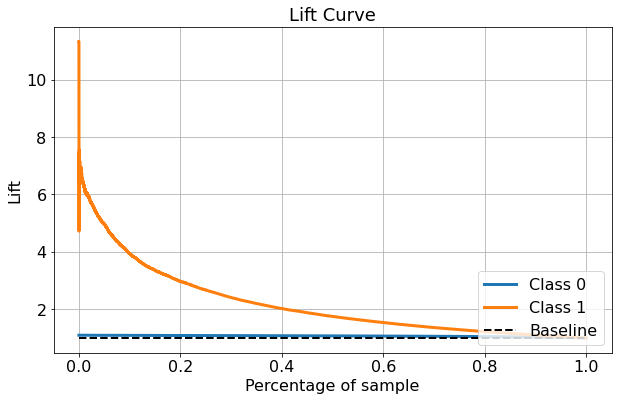



TEST RESULTS:

Accuracy Score: 0.8 

Confusion Matrix:
        pred:0  pred:1
true:0   27974    6237
true:1    1299    1901 

False Positive Rate: 0.18
True Positive Rate: 0.59
AUC: 0.71 

Sensitivity: 0.59
Specificity: 0.82 

F1 Score: 0.34 

KS Score:
KstestResult(statistic=0.13199326401325817, pvalue=1.2204775979655316e-284) 

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.82      0.88     34211
           1       0.23      0.59      0.34      3200

    accuracy                           0.80     37411
   macro avg       0.59      0.71      0.61     37411
weighted avg       0.89      0.80      0.83     37411

Gain Chart


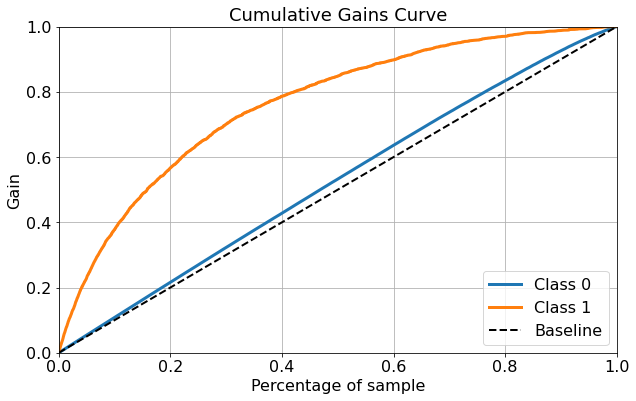

Lift Chart


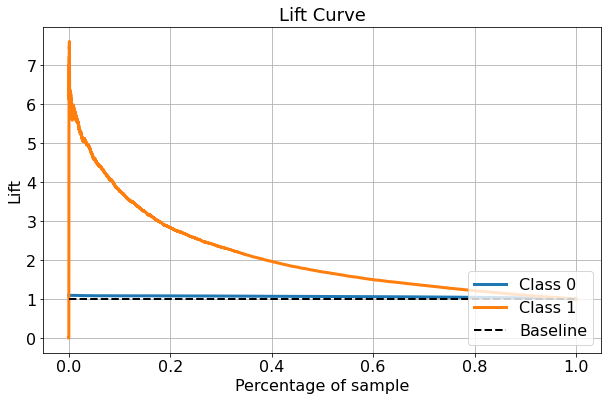



OOT RESULTS:

Accuracy Score: 0.84 

Confusion Matrix:
        pred:0  pred:1
true:0   20184    3453
true:1     728    1009 

False Positive Rate: 0.15
True Positive Rate: 0.58
AUC: 0.72 

Sensitivity: 0.58
Specificity: 0.85 

F1 Score: 0.33 

KS Score:
KstestResult(statistic=0.10739339481358878, pvalue=7.068478274354675e-128) 

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.91     23637
           1       0.23      0.58      0.33      1737

    accuracy                           0.84     25374
   macro avg       0.60      0.72      0.62     25374
weighted avg       0.91      0.84      0.87     25374

Gain Chart


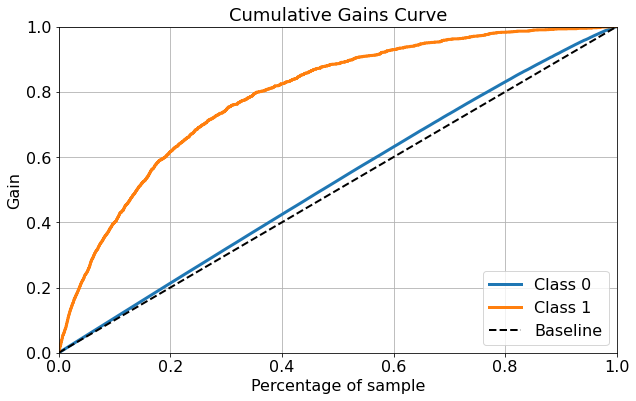

Lift Chart


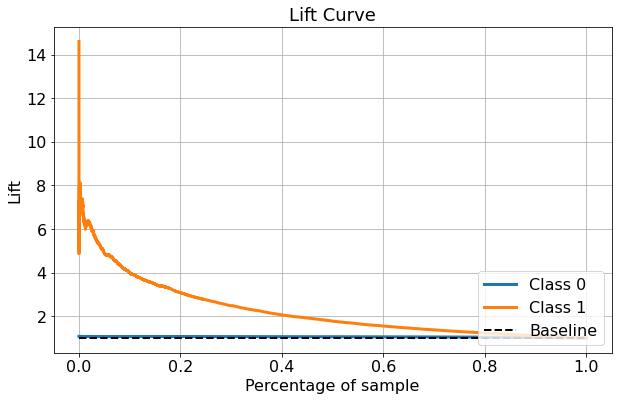

In [52]:
# Using the top 41 features, training the model
top_features_41 = feature_imp_df[:41]['feature'].to_list()
x_tr = x_train[top_features_41]
x_te = x_test[top_features_41]
x_oo = x_oot[top_features_41]


tuned_model7 = XGBClassifier(random_state=3, max_depth=3, scale_pos_weight=7, learning_rate=0.1)
tuned_model7.fit(x_tr, y_train)

# Prediction on the train, test & oot datasets
print("TRAIN RESULTS:\n")
y_pred = tuned_model7.predict(x_tr)
predicted_probas = tuned_model7.predict_proba(x_tr)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = tuned_model7.predict(x_te)
predicted_probas = tuned_model7.predict_proba(x_te)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = tuned_model7.predict(x_oo)
predicted_probas = tuned_model7.predict_proba(x_oo)
model_metrics(y_pred, y_oot, predicted_probas)

### Selecting the optimal number of features

In [53]:
# Feature Importance Custom Function
def feature_importance(model, X, imp_type='gain'):
    '''
    Returns the best binary classifier with tuned hyperparameter set

        Parameters:
                model (object): model object of the binary classifier
                X (dataframe(pandas)): pandas dataframe of predictor variables in train dataset
                imp_type (str): importance type to be plotted from the model, choose from ['gain', 'cover', 'weight', 'total_gain', 'total_cover']
        
        Prints:
                feat_importances (plot): plots the feature importance

        Returns:
                feat_importance (dataframe(pandas)): pandas dataframe of feature importances

        Raises:
                ValueError: If X is not pandas dataframe
    '''
    # Check if train dataset is passed as dataframe
    if type(X) != pd.core.frame.DataFrame:
        raise ValueError('Train dataset not passed as pandas dataframe')
    
    # Check if the classifier is tree based
    if type(model).__name__ in (['DecisionTreeClassifier', 'RandomForestClassifier', 'XGBClassifier']):
        importance_array = model.feature_importances_
    else:
        importance_array = model.coef_[0]
    
    # Extract the feature importance
    feat_importances = pd.DataFrame(importance_array, index=X.columns, columns=['importance'])

    # Plot the feature importance
    # fig = px.bar(feat_importances, orientation='h')
    # fig.update_layout(yaxis={'categoryorder':'total ascending'})
    # fig.show()

    # Return the feature importance dataframe
    return feat_importances
imp = feature_importance(tuned_model7, x_train[top_features_41], imp_type='total_gain')


In [54]:
imp_idx = imp.sort_values(by='importance', ascending=False).index[:41]
imp = imp.loc[imp_idx]

In [56]:
imp.reset_index()

index  importance
0                           estimated_monthly_revenue    0.292805
1                               incoming_ach_payments    0.066970
2                                      business_group    0.041728
3   industry_category_name_professional, scientifi...    0.040900
4                             outgoing_ach_and_checks    0.039407
5                                    sh_sw_ratio_mean    0.035917
6                                   screen_width_mean    0.033160
7                            iovation_device_type_mac    0.028594
8                   socure_emailrisk_reason_code_i566    0.026622
9                                    socure_emailrisk    0.025563
10                                       socure_sigma    0.022522
11                industry_category_name_retail trade    0.022443
12                               check_deposit_amount    0.020730
13                  socure_emailrisk_reason_code_i553    0.019653
14  industry_category_name_real estate rental and ...    0.018653
15                                   socure_phonerisk    0.018207
16                  socure_phonerisk_reason_code_i630    0.017139
17                       iovation_device_type_android    0.015473
18                            socure_reason_code_i121    0.015351
19                            socure_reason_code_r207    0.014789
20                             incoming_wire_transfer    0.013628
21                            outgoing_wire_transfers    0.013220
22                  socure_emailrisk_reason_code_r561    0.012897
23                       iovation_device_timezone_480    0.012085
24                  socure_phonerisk_reason_code_r616    0.011502
25  industry_category_name_administrative and supp...    0.009819
26                  socure_phonerisk_reason_code_i614    0.009452
27                                         page_count    0.008759
28                                email_domain_bucket    0.008704
29                                      carrier_other    0.008546
30                             ida_score_reason_2_946    0.008454
31              industry_category_name_other services    0.008316
32                                    carrier_tmobile    0.008206
33                  socure_phonerisk_reason_code_r639    0.007656
34               industry_category_name_manufacturing    0.007489
35  industry_category_name_health care and social ...    0.007252
36                                 screen_height_mean    0.006826
37                                   verify-email-otp    0.006737
38                  socure_phonerisk_reason_code_r608    0.004865
39                                   line_type_mobile    0.004832
40                            socure_reason_code_i127    0.004130

In [58]:
imp.shape

(41, 1)

Find the optimal number of features

In [62]:
# functions to build models with different feature counts by iteratively removing least important features
def get_feature_importance(X_train, X_test):
    xgb_model = XGBClassifier(max_depth=3, scale_pos_weight=7 ,learning_rate=0.1 ,random_state=3
                              ,eval_metric='logloss')
    xgb_model.fit(X_train, y_train)
    imp = feature_importance(xgb_model, X_train, imp_type='total_gain')
    return imp,xgb_model

def imp_iter(X_train,X_test,imp_data,threshold):
    X_train_temp = X_train.copy()
    X_test_temp = X_test.copy()
    while X_train_temp.shape[1] > threshold:
        features = list(X_train_temp.columns)
        feature_exc = imp_data.sort_values(by='importance', ascending=True).index[0]
        features.remove(feature_exc)
        X_train_temp = X_train_temp[features]
        X_test_temp = X_test_temp[features]
        imp_data, xgb_model2 = get_feature_importance(X_train_temp, X_test_temp)
    print(imp_data.shape[0])
    pd.DataFrame(imp_data.index.to_list(), columns=['column']).to_pickle(project_path+'models_tmp2/top_features_'+str(threshold)+'.pkl')
    pickle.dump(xgb_model2, open(f'{project_path}models_tmp2/xgb_{threshold}.pkl', 'wb'))
    return

def var_imp_iter(X_train,X_test,imp_data,var_arr):
    for threshold in var_arr:
        imp_iter(X_train, X_test, imp_data, threshold)
    return

In [63]:
x_train2 = x_train[top_features_41]
x_test2 = x_test[top_features_41]

In [64]:
# iteratively removing features one by one and saving models with the provided feature counts list.
arr = [10,15,20,25,30,35,40]
var_imp_iter(x_train2,x_test2,imp,arr)

10
15
20
25
30
35
40


In [65]:
# Loading models and comparing their AUC performance
features_count_arr = [40,35,30,25,20,15,10]
model_arr = []
for threshold in features_count_arr:
    model_arr.append(pickle.load(open(f'{project_path}models_tmp2/xgb_{threshold}.pkl', "rb")))
model_arr

[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
               eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
               interaction_constraints='', learning_rate=0.1, max_delta_step=0,
               max_depth=3, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=100, n_jobs=8,
               num_parallel_tree=1, predictor='auto', random_state=3,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=7, subsample=1,
               tree_method='exact', validate_parameters=1, verbosity=None),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
               eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
               interaction_constraints='', learning_rate=0.1, max_delta_step=0,
               max_depth=3

Running each model with iterations over 50 seeds, to check the performance metrics and finalise the number of features for the model.

In [66]:
%load_ext autoreload
%autoreload 2

from modules.validation import validator
val = validator()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
def run_pipe_test(df,  dependent_variable, model, threshold):
    
    print('\n\nNumber of features: ',threshold)
    # Set seed for train test split 
#     selected_features = model.feature_names_in_
    selected_features = pd.read_pickle(project_path+'models_tmp2/top_features_'+str(threshold)+'.pkl')['column'].to_list()
    traindict0, testdict0   = val.rank_order_test(df, selected_features, dependent_variable, model, 0)
    
    results_df = pd.DataFrame(columns=['seed', 
                               'accuracy_train','accuracy_test',
                               'auc_train','auc_test', 
                               'precision_train','precision_test', 
                               'recall_train','recall_test',
                              'fpr_train','fpr_test',
                              'tpr_train','tpr_test',
                              'sensitivity_train','sensitivity_test',
                              'specificity_train','specificity_test'])
    dict0 = {'seed':0, 
             'accuracy_train': traindict0['accuracy_score'], 'accuracy_test':testdict0['accuracy_score'],
             'auc_train' : traindict0['AUC'], 'auc_test' : testdict0['AUC'],
             'precision_train':traindict0['precision'],'precision_test':testdict0['precision'],
             'recall_train':traindict0['recall'], 'recall_test':testdict0['recall'],
             'fpr_train':traindict0['FPR'], 'fpr_test':testdict0['FPR'],
             'tpr_train':traindict0['TPR'], 'tpr_test':testdict0['TPR'],
             'sensitivity_train':traindict0['Sensitivity'], 'sensitivity_test':testdict0['Sensitivity'],
             'specificity_train':traindict0['Specificity'], 'specificity_test':testdict0['Specificity']
            }
    results_df = results_df.append(dict0,ignore_index=True)
    
    for seed in range(1,50):
        print('Seed number: ',seed)
        traindict1, testdict1  = val.rank_order_test(df, selected_features, dependent_variable, model, seed)
        
        dict1 = {'seed':0, 
                 'accuracy_train': traindict1['accuracy_score'], 'accuracy_test':testdict1['accuracy_score'],
                 'auc_train' : traindict1['AUC'], 'auc_test' : testdict1['AUC'],
                 'precision_train':traindict1['precision'],'precision_test':testdict1['precision'],
                 'recall_train':traindict1['recall'], 'recall_test':testdict1['recall'],
                 'fpr_train':traindict1['FPR'], 'fpr_test':testdict1['FPR'],
                 'tpr_train':traindict1['TPR'], 'tpr_test':testdict1['TPR'],
                 'sensitivity_train':traindict1['Sensitivity'], 'sensitivity_test':testdict1['Sensitivity'],
                 'specificity_train':traindict1['Specificity'], 'specificity_test':testdict1['Specificity']
                }
        results_df = results_df.append(dict1,ignore_index=True)
    
    return results_df


In [68]:
x_train_test2 = pd.concat([x_train2, x_test2], axis=0).reset_index(drop=True)
y_train_test2 = pd.DataFrame(np.concatenate([y_train, y_test], axis=0), columns=['ns_flag'])

In [69]:
aucdf = run_pipe_test(x_train_test2.join(y_train_test2),'ns_flag',model_arr[0],max(features_count_arr))
aucdf['tag'] = 'base'

aucdf_main = aucdf.copy()

# for tag,modelx in zip(features_count_arr,model_arr):
for tag,modelx in zip(features_count_arr,model_arr):
    aucdftmp = run_pipe_test(x_train_test2.join(y_train_test2),'ns_flag',modelx, tag)
    aucdftmp['tag'] = tag
    aucdf_main = aucdf_main.append(aucdftmp)



Number of features:  40
Seed number:  1
Seed number:  2
Seed number:  3
Seed number:  4
Seed number:  5
Seed number:  6
Seed number:  7
Seed number:  8
Seed number:  9
Seed number:  10
Seed number:  11
Seed number:  12
Seed number:  13
Seed number:  14
Seed number:  15
Seed number:  16
Seed number:  17
Seed number:  18
Seed number:  19
Seed number:  20
Seed number:  21
Seed number:  22
Seed number:  23
Seed number:  24
Seed number:  25
Seed number:  26
Seed number:  27
Seed number:  28
Seed number:  29
Seed number:  30
Seed number:  31
Seed number:  32
Seed number:  33
Seed number:  34
Seed number:  35
Seed number:  36
Seed number:  37
Seed number:  38
Seed number:  39
Seed number:  40
Seed number:  41
Seed number:  42
Seed number:  43
Seed number:  44
Seed number:  45
Seed number:  46
Seed number:  47
Seed number:  48
Seed number:  49


Number of features:  40
Seed number:  1
Seed number:  2
Seed number:  3
Seed number:  4
Seed number:  5
Seed number:  6
Seed number:  7
Seed number:

In [70]:
aucdf_main

seed  accuracy_train  accuracy_test  auc_train  auc_test  precision_train  \
0    0.0            0.81           0.81    0.71908   0.70797         0.254298   
1    0.0            0.81           0.81    0.71988   0.70454         0.255432   
2    0.0            0.81           0.81    0.71903   0.71143         0.254103   
3    0.0            0.81           0.81    0.71868   0.70426         0.255083   
4    0.0            0.81           0.81    0.71514   0.71671         0.250742   
..   ...             ...            ...        ...       ...              ...   
45   0.0            0.80           0.79    0.70434   0.68921         0.236842   
46   0.0            0.80           0.80    0.69760   0.70084         0.233187   
47   0.0            0.80           0.80    0.70209   0.69311         0.236027   
48   0.0            0.80           0.80    0.70142   0.69439         0.238812   
49   0.0            0.80           0.80    0.69969   0.69444         0.236020   

    precision_test  recall_train  recall_test  fpr_train  fpr_test  tpr_train  \
0         0.252413      0.607292     0.585583       0.17      0.17       0.61   
1         0.251260      0.607631     0.578497       0.17      0.17       0.61   
2         0.244094      0.610822     0.598039       0.17      0.18       0.61   
3         0.251616      0.605583     0.575254       0.17      0.17       0.61   
4         0.255448      0.602016     0.603411       0.17      0.17       0.60   
..             ...           ...          ...        ...       ...        ...   
45        0.223125      0.592642     0.564338       0.18      0.19       0.59   
46        0.233650      0.577129     0.585549       0.18      0.18       0.58   
47        0.234021      0.585202     0.564326       0.18      0.18       0.59   
48        0.226496      0.581992     0.572791       0.18      0.18       0.58   
49        0.233424      0.579693     0.565723       0.18      0.18       0.58   

    tpr_test  sensitivity_train  sensitivity_test  specificity_train  \
0       0.59               0.61              0.59               0.83   
1       0.58               0.61              0.58               0.83   
2       0.60               0.61              0.60               0.83   
3       0.58               0.61              0.58               0.83   
4       0.60               0.60              0.60               0.83   
..       ...                ...               ...                ...   
45      0.56               0.59              0.56               0.82   
46      0.59               0.58              0.59               0.82   
47      0.56               0.59              0.56               0.82   
48      0.57               0.58              0.57               0.82   
49      0.57               0.58              0.57               0.82   

    specificity_test   tag  
0               0.83  base  
1               0.83  base  
2               0.82  base  
3               0.83  base  
4               0.83  base  
..               ...   ...  
45              0.81    10  
46              0.82    10  
47              0.82    10  
48              0.82    10  
49              0.82    10  

[400 rows x 18 columns]

In [71]:
aucdf_main_2 = aucdf_main[~(aucdf_main['tag']=='base')]

#### AUC

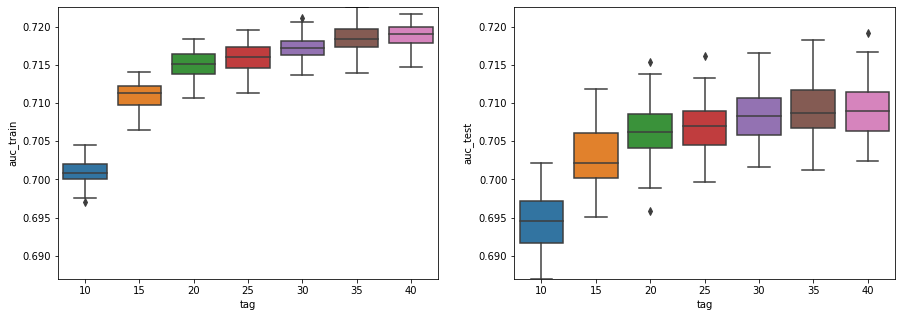

In [72]:
# Plotting the train and test AUC scores of each model averaged over 50 iterations
df_plot = aucdf_main_2.copy()
col_train = 'auc_train'
col_test = 'auc_test'

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)
ax = fig.add_subplot(1,2,1)
sns.boxplot(x="tag", y=col_train, data=df_plot)  # RUN PLOT   
ax.set_ylim(min([min(df_plot[col_train]), min(df_plot[col_test])]), max([max(df_plot[col_train]), max(df_plot[col_test])]))
ax = fig.add_subplot(1,2,2)
sns.boxplot(x="tag", y=col_test, data=df_plot)  # RUN PLOT   
ax.set_ylim(min([min(df_plot[col_train]), min(df_plot[col_test])]), max([max(df_plot[col_train]), max(df_plot[col_test])]))

plt.show()

Train:
- AUC is best at 30 & 40 features, because the variation in the values is less. It explains the model is stable with varying data splits

Test:
- AUC is flat at 30, 35 & 40 features

Basis the above observations the optimal features selected are 30.

#### Recall

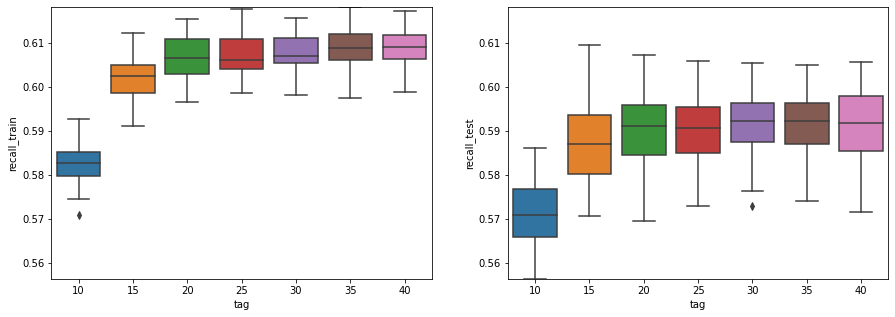

In [73]:
# Plotting the train and test recall scores of each model averaged over 50 iterations
df_plot = aucdf_main_2.copy()
col_train = 'recall_train'
col_test = 'recall_test'

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)
ax = fig.add_subplot(1,2,1)
sns.boxplot(x="tag", y=col_train, data=df_plot)  # RUN PLOT   
ax.set_ylim(min([min(df_plot[col_train]), min(df_plot[col_test])]), max([max(df_plot[col_train]), max(df_plot[col_test])]))
ax = fig.add_subplot(1,2,2)
sns.boxplot(x="tag", y=col_test, data=df_plot)  # RUN PLOT   
ax.set_ylim(min([min(df_plot[col_train]), min(df_plot[col_test])]), max([max(df_plot[col_train]), max(df_plot[col_test])]))

plt.show()

Train:
- Recall is best at 30 & 40 features, because the variation in the values is less. It explains the model is stable with varying data splits

Test:
- Recall is best and flat at 30, 35 & 40 features

Basis the above observations the optimal features selected are 30.

#### Precision

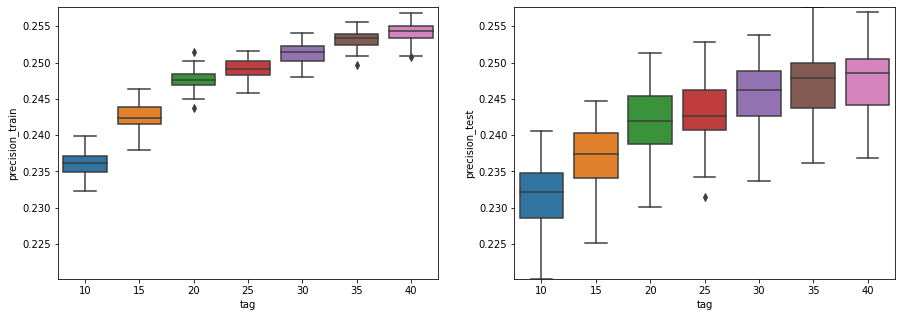

In [74]:
# Plotting the train and test precision scores of each model averaged over 50 iterations
df_plot = aucdf_main_2.copy()
col_train = 'precision_train'
col_test = 'precision_test'

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)
ax = fig.add_subplot(1,2,1)
sns.boxplot(x="tag", y=col_train, data=df_plot)  # RUN PLOT   
ax.set_ylim(min([min(df_plot[col_train]), min(df_plot[col_test])]), max([max(df_plot[col_train]), max(df_plot[col_test])]))
ax = fig.add_subplot(1,2,2)
sns.boxplot(x="tag", y=col_test, data=df_plot)  # RUN PLOT   
ax.set_ylim(min([min(df_plot[col_train]), min(df_plot[col_test])]), max([max(df_plot[col_train]), max(df_plot[col_test])]))

plt.show()

The number of optimal features selected are 30, because the precision value should be greather than or equal to NSL V1 model which comes to be 23%

In [76]:
# Save the top 30 features
top30_features = pd.read_pickle(project_path+'models_tmp2/top_features_30.pkl')['column'].to_list()

In [77]:
top30_features

['estimated_monthly_revenue',
 'incoming_ach_payments',
 'sh_sw_ratio_mean',
 'screen_width_mean',
 'industry_category_name_professional, scientific, and technical services',
 'business_group',
 'outgoing_ach_and_checks',
 'socure_sigma',
 'iovation_device_type_mac',
 'industry_category_name_real estate rental and leasing',
 'socure_emailrisk',
 'socure_emailrisk_reason_code_i566',
 'socure_phonerisk',
 'industry_category_name_retail trade',
 'socure_emailrisk_reason_code_i553',
 'iovation_device_type_android',
 'outgoing_wire_transfers',
 'socure_emailrisk_reason_code_r561',
 'check_deposit_amount',
 'socure_phonerisk_reason_code_i630',
 'socure_reason_code_r207',
 'socure_phonerisk_reason_code_i614',
 'iovation_device_timezone_480',
 'industry_category_name_administrative and support and waste management and remediation services',
 'socure_phonerisk_reason_code_r616',
 'email_domain_bucket',
 'incoming_wire_transfer',
 'industry_category_name_health care and social assistance',
 'soc

Tried running grid search but couldn't get better performance models.
But observed better model metrics by manually varying depth & class weight. So, finlalised the best model basis the model metrics.

In [78]:
estimator2 = XGBClassifier(random_state=3, eval_metric='logloss')

parameters = {
    'max_depth': range (2, 5, 1),
    'learning_rate': [0.05, 0.1, 0.15],
    'scale_pos_weight' : range(4, 8, 1)
}


x_train_test = pd.concat([x_train, x_test], axis=0).reset_index(drop=True)
y_train_test = np.concatenate([y_train, y_test], axis=0)

best_model_v2 = tune_hyperparameters(x_train_test[top30_features], y_train_test, estimator2, parameters, metric='roc_auc', cv_folds=3)


TRAIN RESULTS:

Accuracy Score: 0.86 

Confusion Matrix:
        pred:0  pred:1
true:0   68489    8600
true:1    3586    3879 

False Positive Rate: 0.11
True Positive Rate: 0.52
AUC: 0.7 

Sensitivity: 0.52
Specificity: 0.89 

F1 Score: 0.39 

KS Score:
KstestResult(statistic=0.059299382643044685, pvalue=1.1373855239082134e-129) 

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92     77089
           1       0.31      0.52      0.39      7465

    accuracy                           0.86     84554
   macro avg       0.63      0.70      0.65     84554
weighted avg       0.89      0.86      0.87     84554

Gain Chart


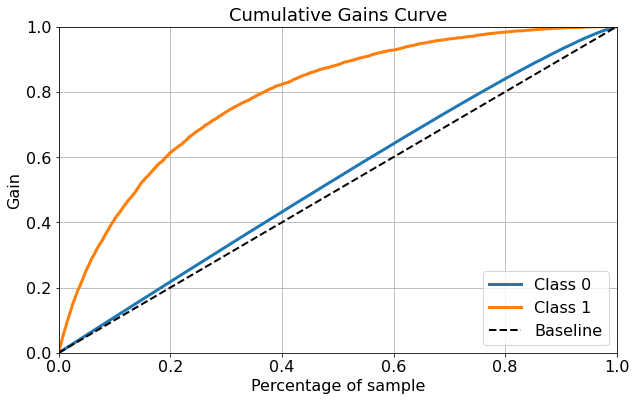

Lift Chart


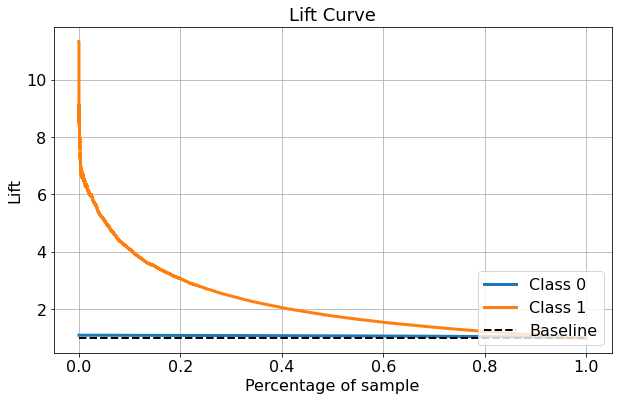



TEST RESULTS:

Accuracy Score: 0.85 

Confusion Matrix:
        pred:0  pred:1
true:0   30170    4041
true:1    1658    1542 

False Positive Rate: 0.12
True Positive Rate: 0.48
AUC: 0.68 

Sensitivity: 0.48
Specificity: 0.88 

F1 Score: 0.35 

KS Score:
KstestResult(statistic=0.06369784288043623, pvalue=1.9934563950849303e-66) 

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91     34211
           1       0.28      0.48      0.35      3200

    accuracy                           0.85     37411
   macro avg       0.61      0.68      0.63     37411
weighted avg       0.89      0.85      0.87     37411

Gain Chart


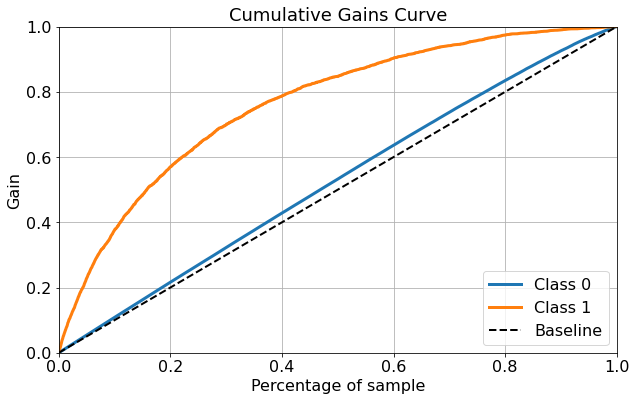

Lift Chart


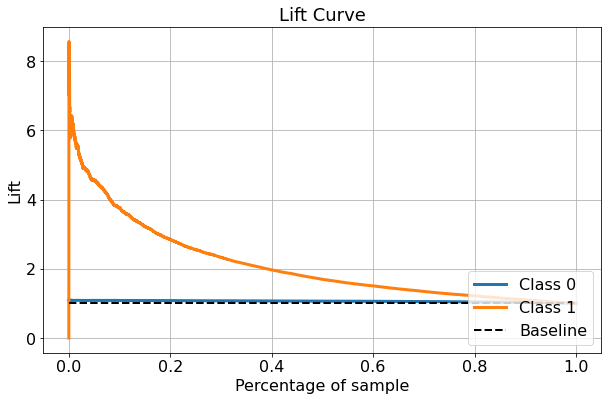



OOT RESULTS:

Accuracy Score: 0.87 

Confusion Matrix:
        pred:0  pred:1
true:0   21113    2524
true:1     892     845 

False Positive Rate: 0.11
True Positive Rate: 0.49
AUC: 0.69 

Sensitivity: 0.49
Specificity: 0.89 

F1 Score: 0.33 

KS Score:
KstestResult(statistic=0.06431780562780798, pvalue=4.515892534833546e-46) 

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.93     23637
           1       0.25      0.49      0.33      1737

    accuracy                           0.87     25374
   macro avg       0.61      0.69      0.63     25374
weighted avg       0.91      0.87      0.88     25374

Gain Chart


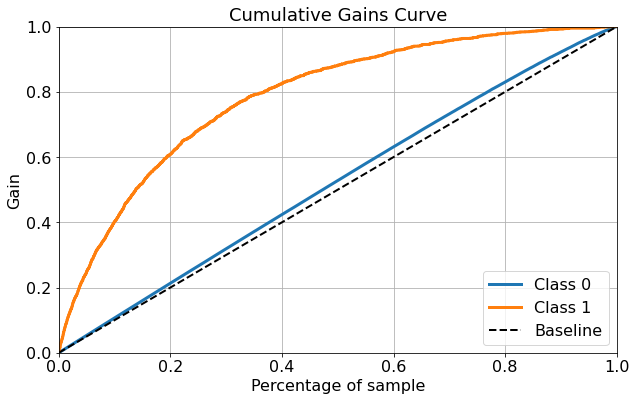

Lift Chart


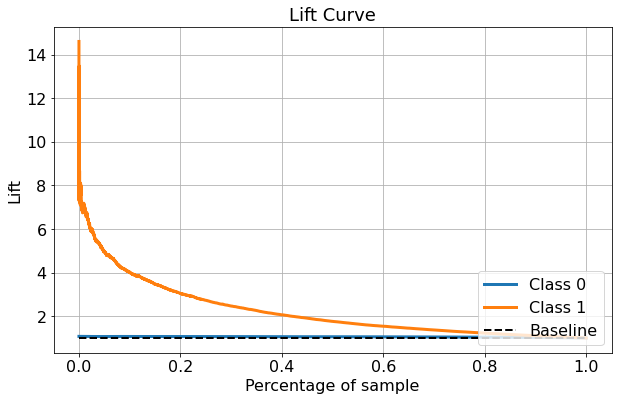

In [93]:
# Depth:4 and Weight:5
x_tr = x_train[top30_features]
x_te = x_test[top30_features]
x_oo = x_oot[top30_features]


tuned_model6 = XGBClassifier(random_state=3, max_depth=4, scale_pos_weight=5, learning_rate=0.1, eval_metric='logloss')
tuned_model6.fit(x_tr, y_train)

###################################
depth = 4
weight = 5
file_name = 'nsql_model_depth_'+str(depth)+'_weight_'+str(weight)+'.pkl'
path = project_path + 'models_tmp2/'
pickle.dump(tuned_model6, open(path + file_name, "wb"))
###################################

# Prediction on the train, test & oot datasets
print("TRAIN RESULTS:\n")
y_pred = tuned_model6.predict(x_tr)
predicted_probas = tuned_model6.predict_proba(x_tr)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = tuned_model6.predict(x_te)
predicted_probas = tuned_model6.predict_proba(x_te)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = tuned_model6.predict(x_oo)
predicted_probas = tuned_model6.predict_proba(x_oo)
model_metrics(y_pred, y_oot, predicted_probas)

TRAIN RESULTS:

Accuracy Score: 0.83 

Confusion Matrix:
        pred:0  pred:1
true:0   65964   11125
true:1    3119    4346 

False Positive Rate: 0.14
True Positive Rate: 0.58
AUC: 0.72 

Sensitivity: 0.58
Specificity: 0.86 

F1 Score: 0.38 

KS Score:
KstestResult(statistic=0.09468505333869481, pvalue=0.0) 

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.86      0.90     77089
           1       0.28      0.58      0.38      7465

    accuracy                           0.83     84554
   macro avg       0.62      0.72      0.64     84554
weighted avg       0.90      0.83      0.86     84554

Gain Chart


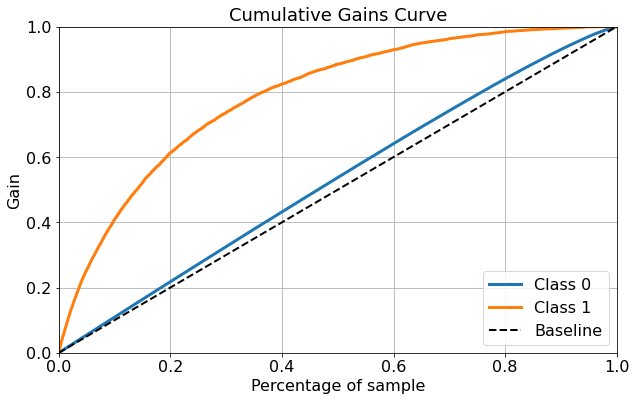

Lift Chart


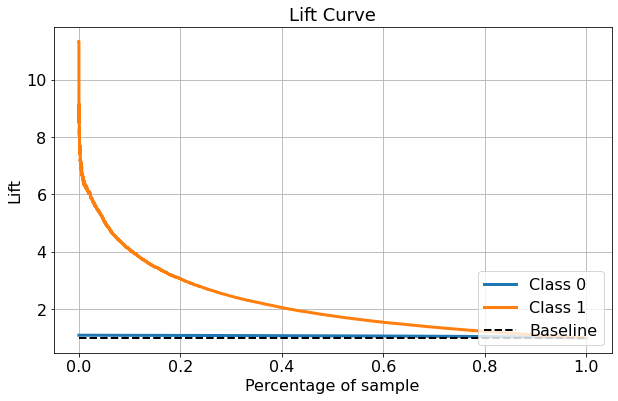



TEST RESULTS:

Accuracy Score: 0.82 

Confusion Matrix:
        pred:0  pred:1
true:0   28986    5225
true:1    1449    1751 

False Positive Rate: 0.15
True Positive Rate: 0.55
AUC: 0.7 

Sensitivity: 0.55
Specificity: 0.85 

F1 Score: 0.34 

KS Score:
KstestResult(statistic=0.10093288070353645, pvalue=2.3608361700044428e-166) 

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90     34211
           1       0.25      0.55      0.34      3200

    accuracy                           0.82     37411
   macro avg       0.60      0.70      0.62     37411
weighted avg       0.89      0.82      0.85     37411

Gain Chart


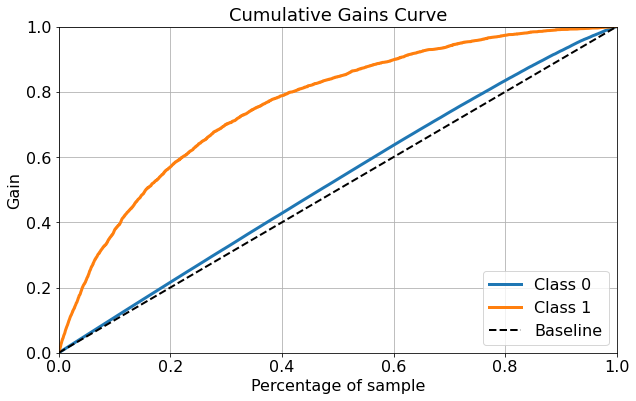

Lift Chart


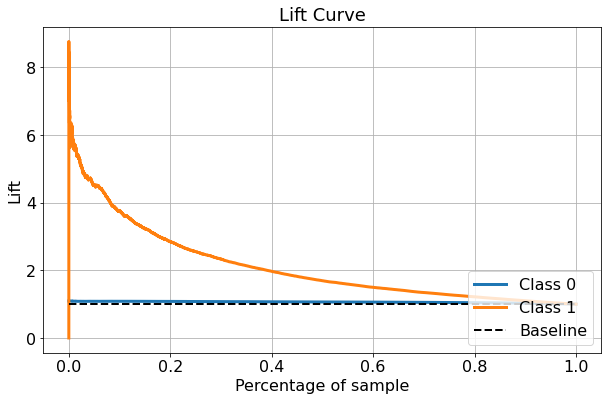



OOT RESULTS:

Accuracy Score: 0.84 

Confusion Matrix:
        pred:0  pred:1
true:0   20437    3200
true:1     774     963 

False Positive Rate: 0.14
True Positive Rate: 0.55
AUC: 0.71 

Sensitivity: 0.55
Specificity: 0.86 

F1 Score: 0.33 

KS Score:
KstestResult(statistic=0.09560967919918029, pvalue=2.163722712159478e-101) 

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.86      0.91     23637
           1       0.23      0.55      0.33      1737

    accuracy                           0.84     25374
   macro avg       0.60      0.71      0.62     25374
weighted avg       0.91      0.84      0.87     25374

Gain Chart


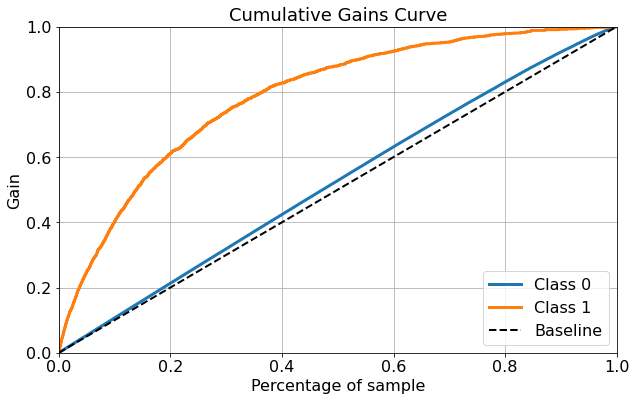

Lift Chart


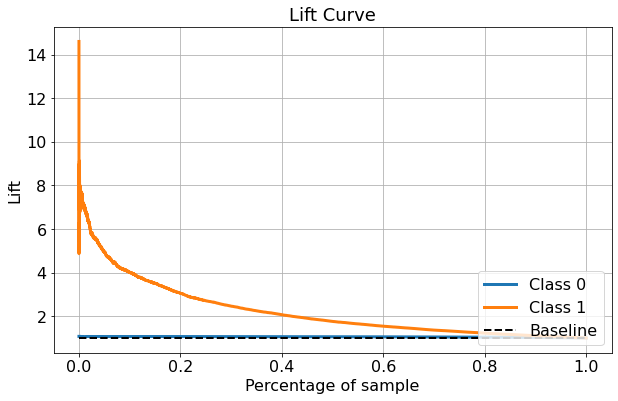

In [94]:
# Depth:4 and Weight:6
x_tr = x_train[top30_features]
x_te = x_test[top30_features]
x_oo = x_oot[top30_features]


tuned_model6 = XGBClassifier(random_state=3, max_depth=4, scale_pos_weight=6, learning_rate=0.1, eval_metric='logloss')
tuned_model6.fit(x_tr, y_train)

###################################
depth = 4
weight = 6
file_name = 'nsql_model_depth_'+str(depth)+'_weight_'+str(weight)+'.pkl'
path = project_path + 'models_tmp2/'
pickle.dump(tuned_model6, open(path + file_name, "wb"))
###################################

# Prediction on the train, test & oot datasets
print("TRAIN RESULTS:\n")
y_pred = tuned_model6.predict(x_tr)
predicted_probas = tuned_model6.predict_proba(x_tr)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = tuned_model6.predict(x_te)
predicted_probas = tuned_model6.predict_proba(x_te)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = tuned_model6.predict(x_oo)
predicted_probas = tuned_model6.predict_proba(x_oo)
model_metrics(y_pred, y_oot, predicted_probas)

TRAIN RESULTS:

Accuracy Score: 0.81 

Confusion Matrix:
        pred:0  pred:1
true:0   63554   13535
true:1    2731    4734 

False Positive Rate: 0.18
True Positive Rate: 0.63
AUC: 0.73 

Sensitivity: 0.63
Specificity: 0.82 

F1 Score: 0.37 

KS Score:
KstestResult(statistic=0.12777633228469387, pvalue=0.0) 

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.82      0.89     77089
           1       0.26      0.63      0.37      7465

    accuracy                           0.81     84554
   macro avg       0.61      0.73      0.63     84554
weighted avg       0.90      0.81      0.84     84554

Gain Chart


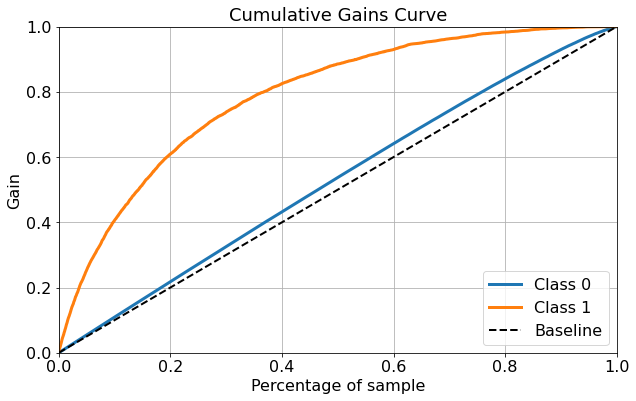

Lift Chart


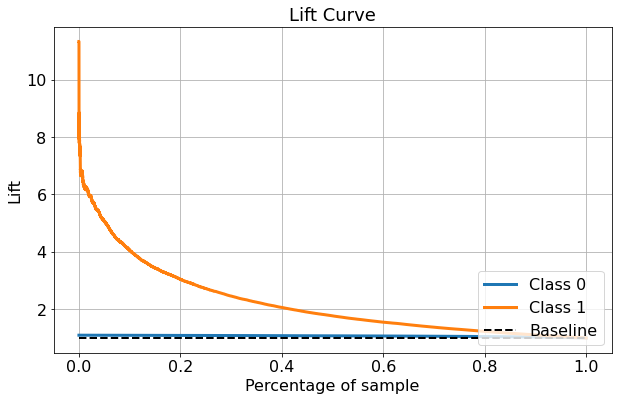



TEST RESULTS:

Accuracy Score: 0.8 

Confusion Matrix:
        pred:0  pred:1
true:0   27901    6310
true:1    1301    1899 

False Positive Rate: 0.18
True Positive Rate: 0.59
AUC: 0.7 

Sensitivity: 0.59
Specificity: 0.82 

F1 Score: 0.33 

KS Score:
KstestResult(statistic=0.13389110154767314, pvalue=6.637452677992685e-293) 

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.82      0.88     34211
           1       0.23      0.59      0.33      3200

    accuracy                           0.80     37411
   macro avg       0.59      0.70      0.61     37411
weighted avg       0.89      0.80      0.83     37411

Gain Chart


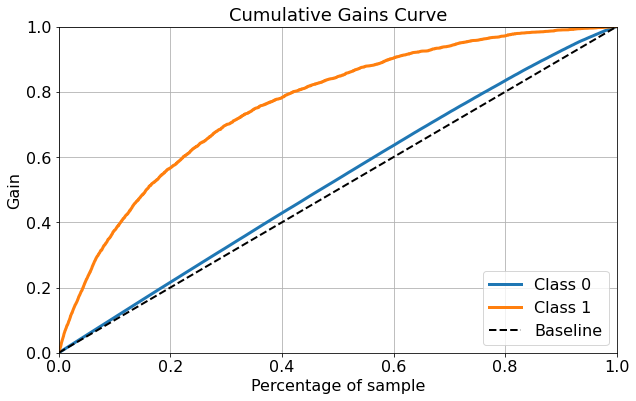

Lift Chart


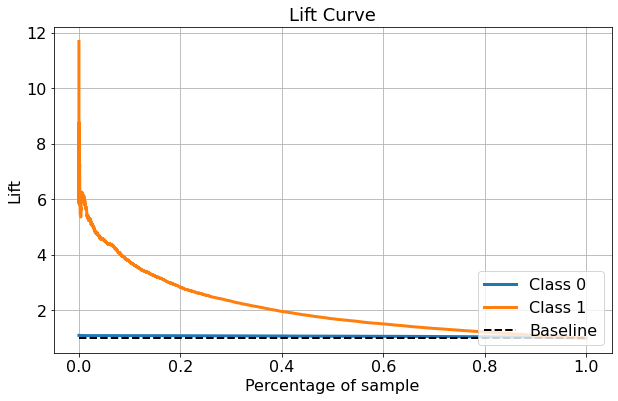



OOT RESULTS:

Accuracy Score: 0.82 

Confusion Matrix:
        pred:0  pred:1
true:0   19759    3878
true:1     708    1029 

False Positive Rate: 0.16
True Positive Rate: 0.59
AUC: 0.71 

Sensitivity: 0.59
Specificity: 0.84 

F1 Score: 0.31 

KS Score:
KstestResult(statistic=0.1249310317647987, pvalue=4.698037784931307e-173) 

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.84      0.90     23637
           1       0.21      0.59      0.31      1737

    accuracy                           0.82     25374
   macro avg       0.59      0.71      0.60     25374
weighted avg       0.91      0.82      0.86     25374

Gain Chart


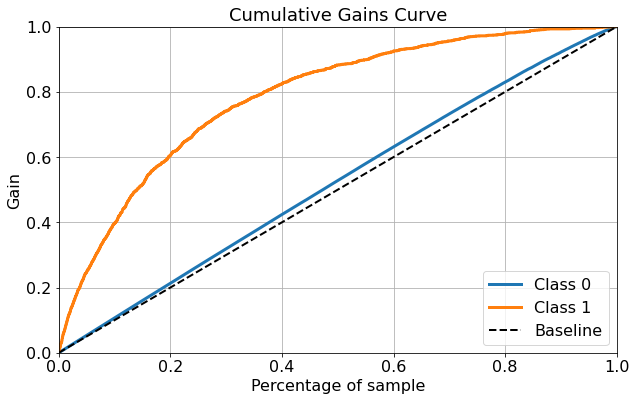

Lift Chart


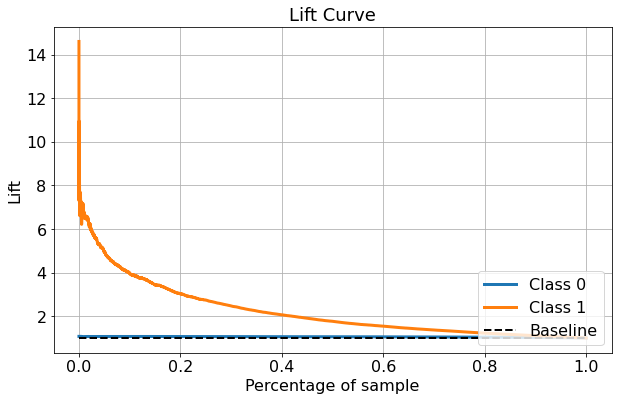

In [97]:
# Depth:4 and Weight:7
x_tr = x_train[top30_features]
x_te = x_test[top30_features]
x_oo = x_oot[top30_features]


tuned_model6 = XGBClassifier(random_state=3, max_depth=4, scale_pos_weight=7, learning_rate=0.1, eval_metric='logloss')
tuned_model6.fit(x_tr, y_train)

###################################
depth = 4
weight = 7
file_name = 'nsql_model_depth_'+str(depth)+'_weight_'+str(weight)+'.pkl'
path = project_path + 'models_tmp2/'
pickle.dump(tuned_model6, open(path + file_name, "wb"))
###################################

# Prediction on the train, test & oot datasets
print("TRAIN RESULTS:\n")
y_pred = tuned_model6.predict(x_tr)
predicted_probas = tuned_model6.predict_proba(x_tr)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = tuned_model6.predict(x_te)
predicted_probas = tuned_model6.predict_proba(x_te)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = tuned_model6.predict(x_oo)
predicted_probas = tuned_model6.predict_proba(x_oo)
model_metrics(y_pred, y_oot, predicted_probas)

TRAIN RESULTS:

Accuracy Score: 0.79 

Confusion Matrix:
        pred:0  pred:1
true:0   61545   15544
true:1    2448    5017 

False Positive Rate: 0.2
True Positive Rate: 0.67
AUC: 0.74 

Sensitivity: 0.67
Specificity: 0.8 

F1 Score: 0.36 

KS Score:
KstestResult(statistic=0.15488326986304612, pvalue=0.0) 

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.80      0.87     77089
           1       0.24      0.67      0.36      7465

    accuracy                           0.79     84554
   macro avg       0.60      0.74      0.62     84554
weighted avg       0.90      0.79      0.83     84554

Gain Chart


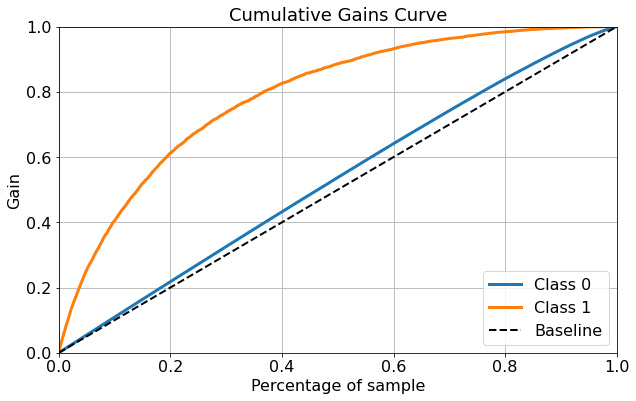

Lift Chart


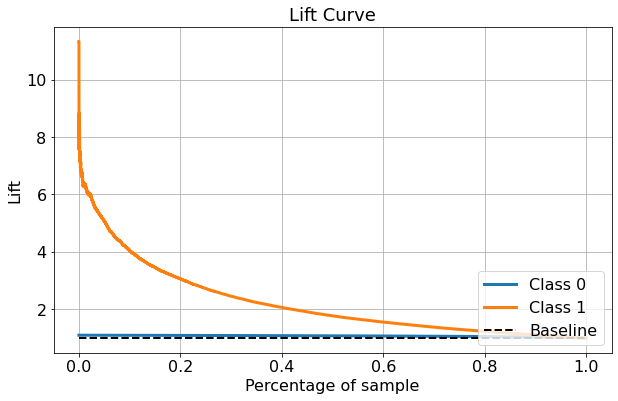



TEST RESULTS:

Accuracy Score: 0.78 

Confusion Matrix:
        pred:0  pred:1
true:0   27022    7189
true:1    1165    2035 

False Positive Rate: 0.21
True Positive Rate: 0.64
AUC: 0.71 

Sensitivity: 0.64
Specificity: 0.79 

F1 Score: 0.33 

KS Score:
KstestResult(statistic=0.16102215925797225, pvalue=0.0) 

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.79      0.87     34211
           1       0.22      0.64      0.33      3200

    accuracy                           0.78     37411
   macro avg       0.59      0.71      0.60     37411
weighted avg       0.90      0.78      0.82     37411

Gain Chart


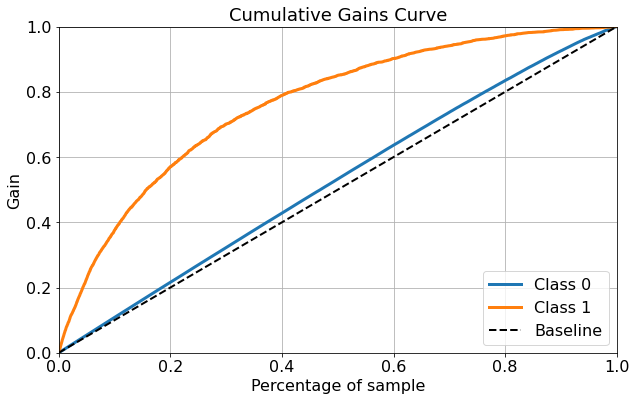

Lift Chart


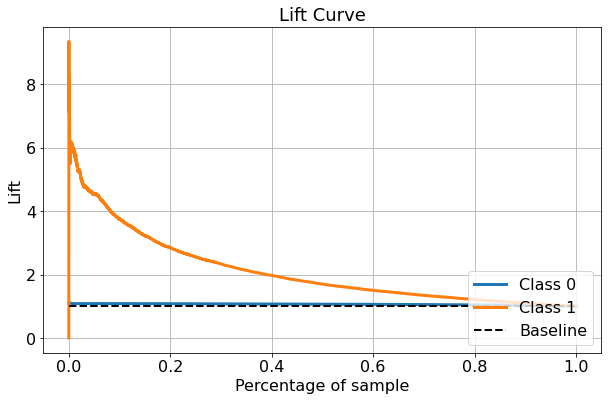



OOT RESULTS:

Accuracy Score: 0.8 

Confusion Matrix:
        pred:0  pred:1
true:0   19133    4504
true:1     629    1108 

False Positive Rate: 0.19
True Positive Rate: 0.64
AUC: 0.72 

Sensitivity: 0.64
Specificity: 0.81 

F1 Score: 0.3 

KS Score:
KstestResult(statistic=0.15271537794592893, pvalue=8.107600975375717e-259) 

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.81      0.88     23637
           1       0.20      0.64      0.30      1737

    accuracy                           0.80     25374
   macro avg       0.58      0.72      0.59     25374
weighted avg       0.92      0.80      0.84     25374

Gain Chart


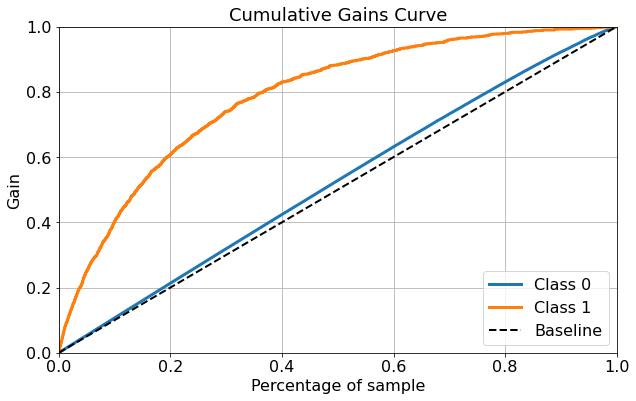

Lift Chart


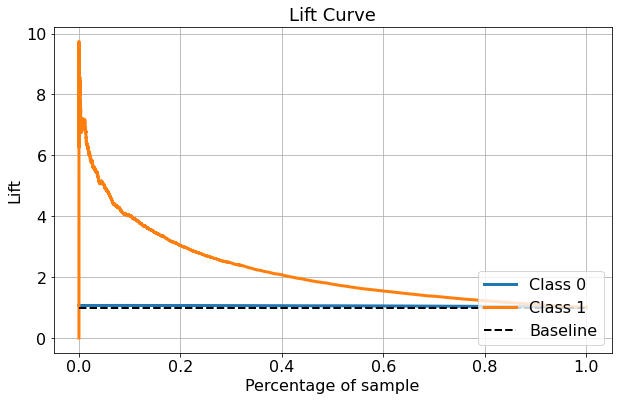

In [98]:
# Depth:4 and Weight:8
x_tr = x_train[top30_features]
x_te = x_test[top30_features]
x_oo = x_oot[top30_features]


tuned_model6 = XGBClassifier(random_state=3, max_depth=4, scale_pos_weight=8, learning_rate=0.1, eval_metric='logloss')
tuned_model6.fit(x_tr, y_train)

###################################
depth = 4
weight = 8
file_name = 'nsql_model_depth_'+str(depth)+'_weight_'+str(weight)+'.pkl'
path = project_path + 'models_tmp2/'
pickle.dump(tuned_model6, open(path + file_name, "wb"))
###################################

# Prediction on the train, test & oot datasets
print("TRAIN RESULTS:\n")
y_pred = tuned_model6.predict(x_tr)
predicted_probas = tuned_model6.predict_proba(x_tr)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = tuned_model6.predict(x_te)
predicted_probas = tuned_model6.predict_proba(x_te)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = tuned_model6.predict(x_oo)
predicted_probas = tuned_model6.predict_proba(x_oo)
model_metrics(y_pred, y_oot, predicted_probas)

TRAIN RESULTS:

Accuracy Score: 0.85 

Confusion Matrix:
        pred:0  pred:1
true:0   68297    8792
true:1    3749    3716 

False Positive Rate: 0.11
True Positive Rate: 0.5
AUC: 0.69 

Sensitivity: 0.5
Specificity: 0.89 

F1 Score: 0.37 

KS Score:
KstestResult(statistic=0.05964235872933277, pvalue=3.5928410552048485e-131) 

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92     77089
           1       0.30      0.50      0.37      7465

    accuracy                           0.85     84554
   macro avg       0.62      0.69      0.64     84554
weighted avg       0.89      0.85      0.87     84554

Gain Chart


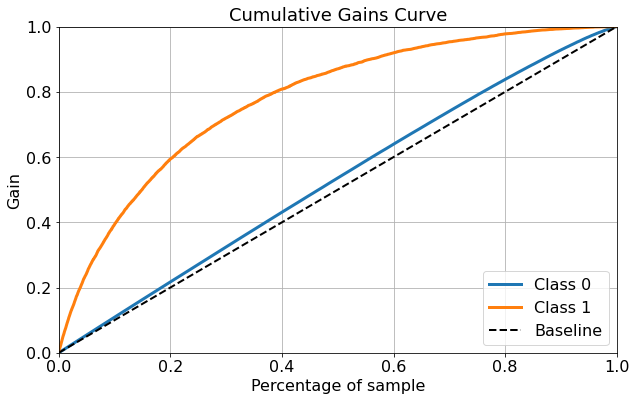

Lift Chart


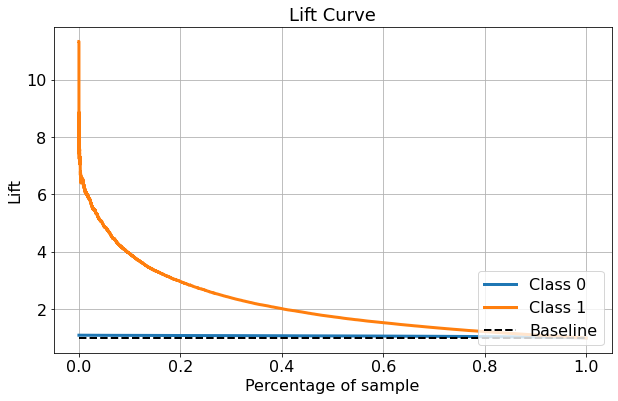



TEST RESULTS:

Accuracy Score: 0.85 

Confusion Matrix:
        pred:0  pred:1
true:0   30175    4036
true:1    1649    1551 

False Positive Rate: 0.12
True Positive Rate: 0.48
AUC: 0.68 

Sensitivity: 0.48
Specificity: 0.88 

F1 Score: 0.35 

KS Score:
KstestResult(statistic=0.06380476330491036, pvalue=1.1958487811088128e-66) 

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91     34211
           1       0.28      0.48      0.35      3200

    accuracy                           0.85     37411
   macro avg       0.61      0.68      0.63     37411
weighted avg       0.89      0.85      0.87     37411

Gain Chart


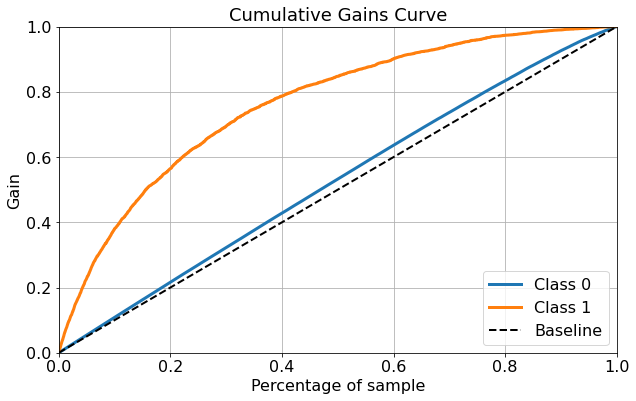

Lift Chart


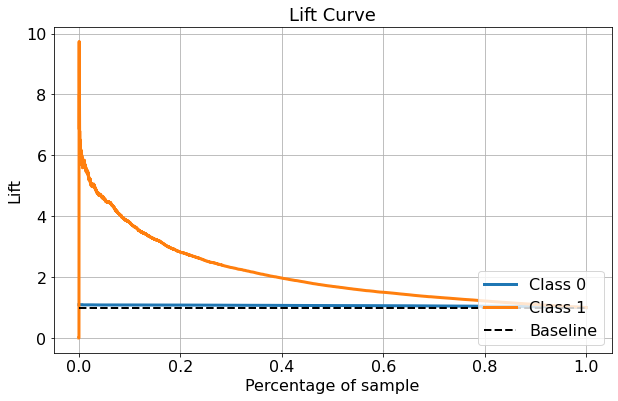



OOT RESULTS:

Accuracy Score: 0.87 

Confusion Matrix:
        pred:0  pred:1
true:0   21150    2487
true:1     907     830 

False Positive Rate: 0.11
True Positive Rate: 0.48
AUC: 0.69 

Sensitivity: 0.48
Specificity: 0.89 

F1 Score: 0.33 

KS Score:
KstestResult(statistic=0.062268463781823935, pvalue=3.3047136606332438e-43) 

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.93     23637
           1       0.25      0.48      0.33      1737

    accuracy                           0.87     25374
   macro avg       0.60      0.69      0.63     25374
weighted avg       0.91      0.87      0.88     25374

Gain Chart


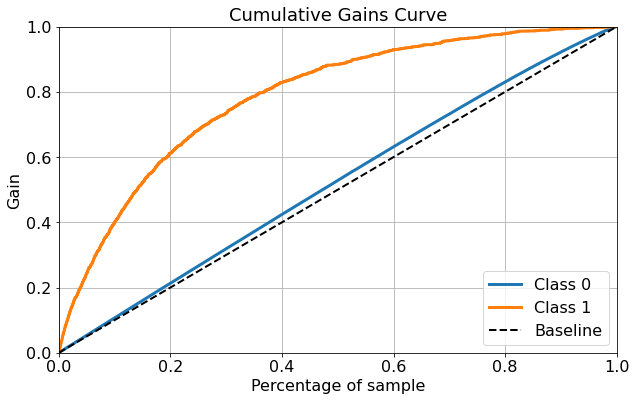

Lift Chart


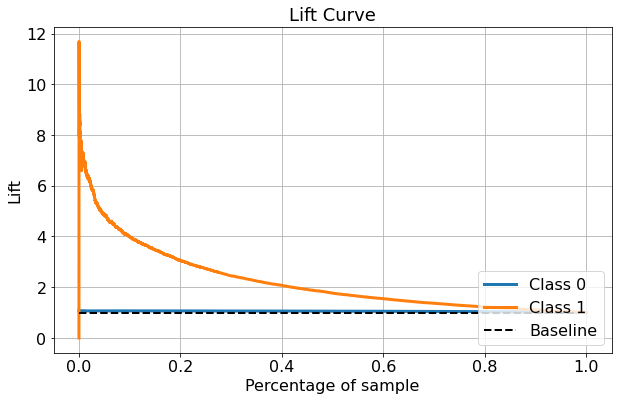

In [99]:
# Depth:3 and Weight:5
x_tr = x_train[top30_features]
x_te = x_test[top30_features]
x_oo = x_oot[top30_features]


tuned_model6 = XGBClassifier(random_state=3, max_depth=3, scale_pos_weight=5, learning_rate=0.1, eval_metric='logloss')
tuned_model6.fit(x_tr, y_train)

###################################
depth = 3
weight = 5
file_name = 'nsql_model_depth_'+str(depth)+'_weight_'+str(weight)+'.pkl'
path = project_path + 'models_tmp2/'
pickle.dump(tuned_model6, open(path + file_name, "wb"))
###################################

# Prediction on the train, test & oot datasets
print("TRAIN RESULTS:\n")
y_pred = tuned_model6.predict(x_tr)
predicted_probas = tuned_model6.predict_proba(x_tr)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = tuned_model6.predict(x_te)
predicted_probas = tuned_model6.predict_proba(x_te)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = tuned_model6.predict(x_oo)
predicted_probas = tuned_model6.predict_proba(x_oo)
model_metrics(y_pred, y_oot, predicted_probas)

TRAIN RESULTS:

Accuracy Score: 0.83 

Confusion Matrix:
        pred:0  pred:1
true:0   65776   11313
true:1    3237    4228 

False Positive Rate: 0.15
True Positive Rate: 0.57
AUC: 0.71 

Sensitivity: 0.57
Specificity: 0.85 

F1 Score: 0.37 

KS Score:
KstestResult(statistic=0.09551292665042466, pvalue=0.0) 

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90     77089
           1       0.27      0.57      0.37      7465

    accuracy                           0.83     84554
   macro avg       0.61      0.71      0.63     84554
weighted avg       0.89      0.83      0.85     84554

Gain Chart


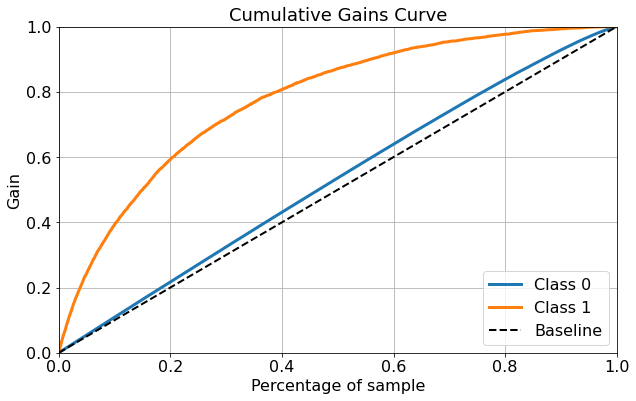

Lift Chart


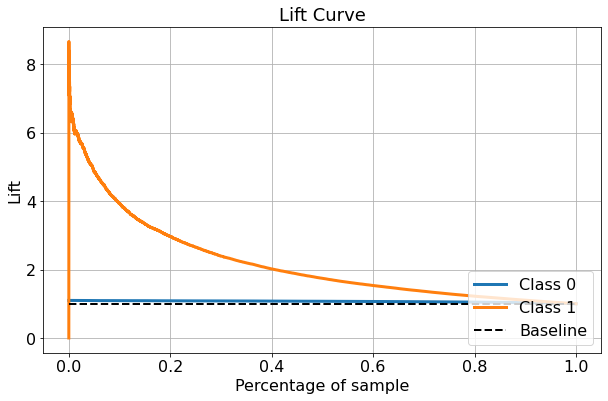



TEST RESULTS:

Accuracy Score: 0.82 

Confusion Matrix:
        pred:0  pred:1
true:0   28964    5247
true:1    1458    1742 

False Positive Rate: 0.15
True Positive Rate: 0.54
AUC: 0.7 

Sensitivity: 0.54
Specificity: 0.85 

F1 Score: 0.34 

KS Score:
KstestResult(statistic=0.10128037208307716, pvalue=1.6828918790107357e-167) 

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90     34211
           1       0.25      0.54      0.34      3200

    accuracy                           0.82     37411
   macro avg       0.60      0.70      0.62     37411
weighted avg       0.89      0.82      0.85     37411

Gain Chart


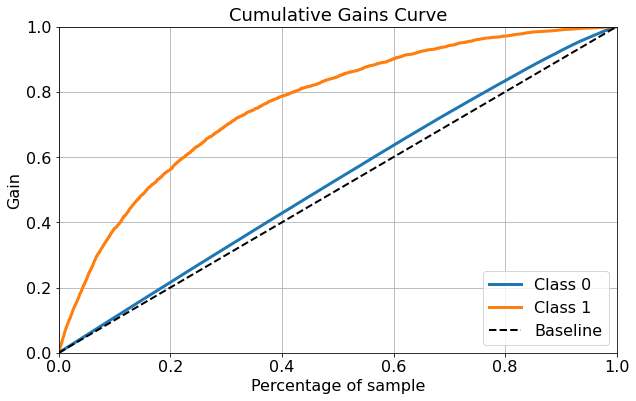

Lift Chart


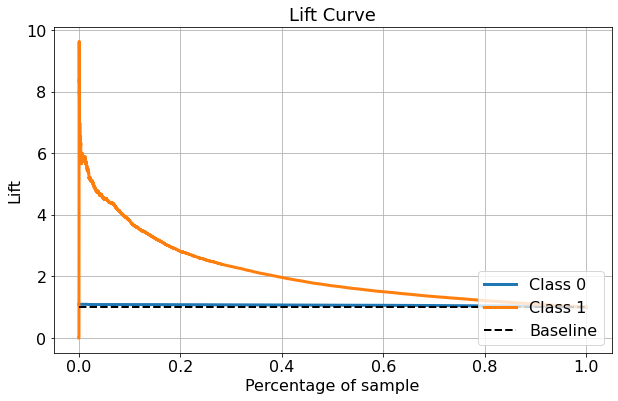



OOT RESULTS:

Accuracy Score: 0.84 

Confusion Matrix:
        pred:0  pred:1
true:0   20446    3191
true:1     794     943 

False Positive Rate: 0.14
True Positive Rate: 0.54
AUC: 0.7 

Sensitivity: 0.54
Specificity: 0.86 

F1 Score: 0.32 

KS Score:
KstestResult(statistic=0.09446677701584305, pvalue=5.4840186905508106e-99) 

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.86      0.91     23637
           1       0.23      0.54      0.32      1737

    accuracy                           0.84     25374
   macro avg       0.60      0.70      0.62     25374
weighted avg       0.91      0.84      0.87     25374

Gain Chart


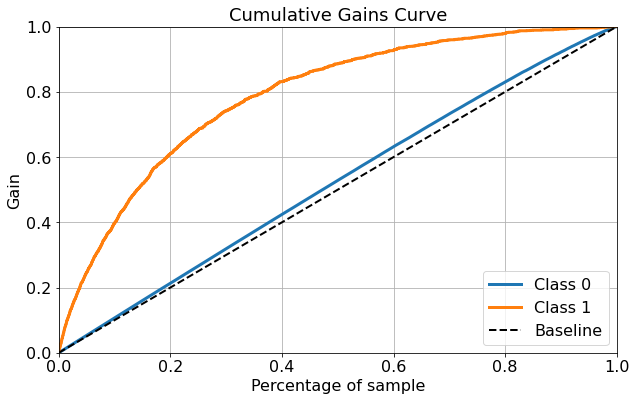

Lift Chart


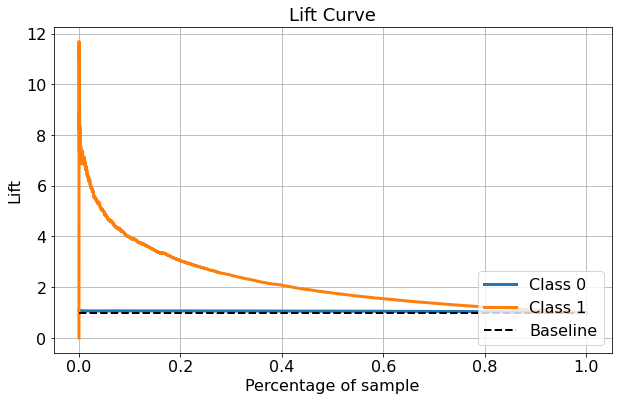

In [100]:
# Depth:3 and Weight:6
x_tr = x_train[top30_features]
x_te = x_test[top30_features]
x_oo = x_oot[top30_features]


tuned_model6 = XGBClassifier(random_state=3, max_depth=3, scale_pos_weight=6, learning_rate=0.1, eval_metric='logloss')
tuned_model6.fit(x_tr, y_train)

###################################
depth = 3
weight = 6
file_name = 'nsql_model_depth_'+str(depth)+'_weight_'+str(weight)+'.pkl'
path = project_path + 'models_tmp2/'
pickle.dump(tuned_model6, open(path + file_name, "wb"))
###################################

# Prediction on the train, test & oot datasets
print("TRAIN RESULTS:\n")
y_pred = tuned_model6.predict(x_tr)
predicted_probas = tuned_model6.predict_proba(x_tr)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = tuned_model6.predict(x_te)
predicted_probas = tuned_model6.predict_proba(x_te)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = tuned_model6.predict(x_oo)
predicted_probas = tuned_model6.predict_proba(x_oo)
model_metrics(y_pred, y_oot, predicted_probas)

TRAIN RESULTS:

Accuracy Score: 0.81 

Confusion Matrix:
        pred:0  pred:1
true:0   63478   13611
true:1    2859    4606 

False Positive Rate: 0.18
True Positive Rate: 0.62
AUC: 0.72 

Sensitivity: 0.62
Specificity: 0.82 

F1 Score: 0.36 

KS Score:
KstestResult(statistic=0.1271613406816946, pvalue=0.0) 

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.82      0.89     77089
           1       0.25      0.62      0.36      7465

    accuracy                           0.81     84554
   macro avg       0.60      0.72      0.62     84554
weighted avg       0.89      0.81      0.84     84554

Gain Chart


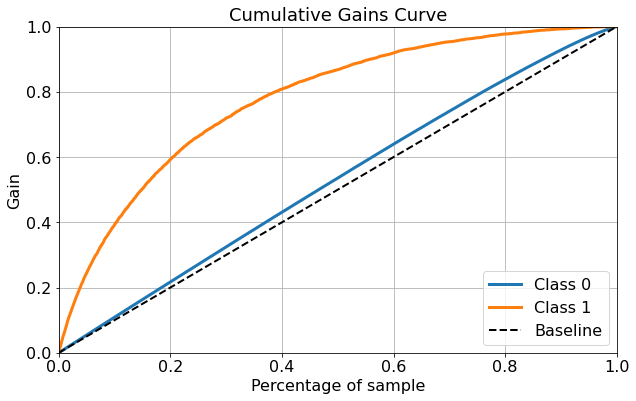

Lift Chart


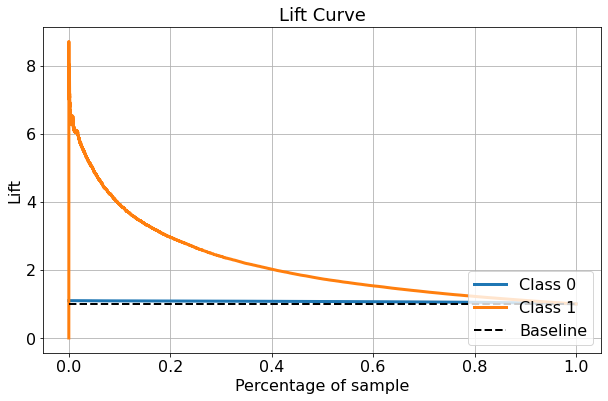



TEST RESULTS:

Accuracy Score: 0.8 

Confusion Matrix:
        pred:0  pred:1
true:0   27896    6315
true:1    1289    1911 

False Positive Rate: 0.18
True Positive Rate: 0.6
AUC: 0.71 

Sensitivity: 0.6
Specificity: 0.82 

F1 Score: 0.33 

KS Score:
KstestResult(statistic=0.1343455133516881, pvalue=6.68931405032902e-295) 

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.82      0.88     34211
           1       0.23      0.60      0.33      3200

    accuracy                           0.80     37411
   macro avg       0.59      0.71      0.61     37411
weighted avg       0.89      0.80      0.83     37411

Gain Chart


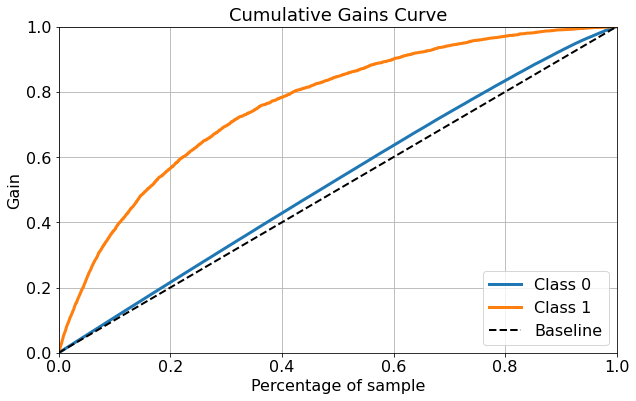

Lift Chart


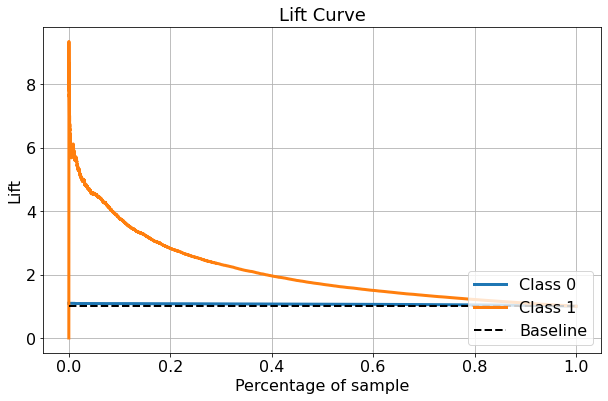



OOT RESULTS:

Accuracy Score: 0.82 

Confusion Matrix:
        pred:0  pred:1
true:0   19776    3861
true:1     688    1049 

False Positive Rate: 0.16
True Positive Rate: 0.6
AUC: 0.72 

Sensitivity: 0.6
Specificity: 0.84 

F1 Score: 0.32 

KS Score:
KstestResult(statistic=0.12504926302514385, pvalue=2.2075080158811993e-173) 

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.84      0.90     23637
           1       0.21      0.60      0.32      1737

    accuracy                           0.82     25374
   macro avg       0.59      0.72      0.61     25374
weighted avg       0.91      0.82      0.86     25374

Gain Chart


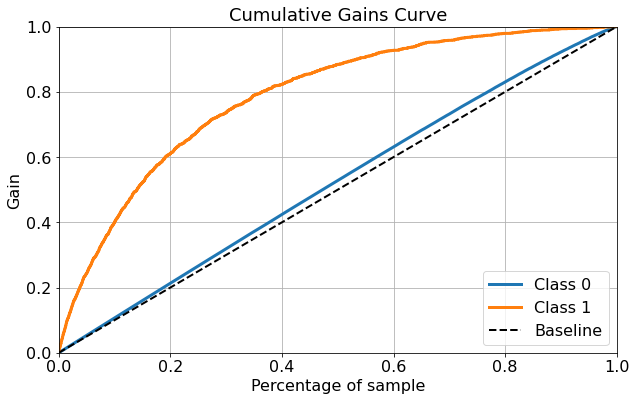

Lift Chart


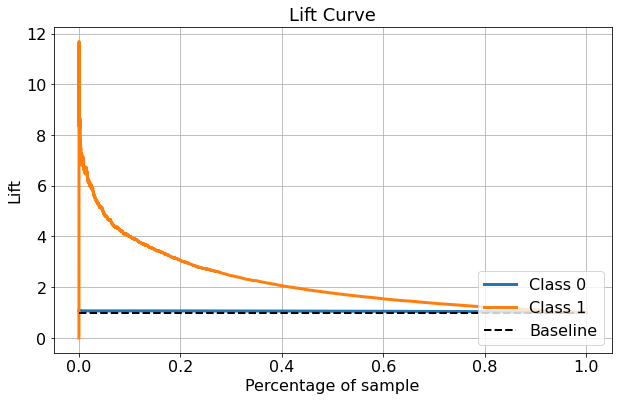

In [101]:
# Depth:3 and Weight:7
x_tr = x_train[top30_features]
x_te = x_test[top30_features]
x_oo = x_oot[top30_features]


tuned_model6 = XGBClassifier(random_state=3, max_depth=3, scale_pos_weight=7, learning_rate=0.1, eval_metric='logloss')
tuned_model6.fit(x_tr, y_train)

###################################
depth = 3
weight = 7
file_name = 'nsql_model_depth_'+str(depth)+'_weight_'+str(weight)+'.pkl'
path = project_path + 'models_tmp2/'
pickle.dump(tuned_model6, open(path + file_name, "wb"))
###################################

# Prediction on the train, test & oot datasets
print("TRAIN RESULTS:\n")
y_pred = tuned_model6.predict(x_tr)
predicted_probas = tuned_model6.predict_proba(x_tr)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = tuned_model6.predict(x_te)
predicted_probas = tuned_model6.predict_proba(x_te)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = tuned_model6.predict(x_oo)
predicted_probas = tuned_model6.predict_proba(x_oo)
model_metrics(y_pred, y_oot, predicted_probas)

TRAIN RESULTS:

Accuracy Score: 0.78 

Confusion Matrix:
        pred:0  pred:1
true:0   61363   15726
true:1    2570    4895 

False Positive Rate: 0.2
True Positive Rate: 0.66
AUC: 0.73 

Sensitivity: 0.66
Specificity: 0.8 

F1 Score: 0.35 

KS Score:
KstestResult(statistic=0.15559287555881451, pvalue=0.0) 

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.80      0.87     77089
           1       0.24      0.66      0.35      7465

    accuracy                           0.78     84554
   macro avg       0.60      0.73      0.61     84554
weighted avg       0.90      0.78      0.82     84554

Gain Chart


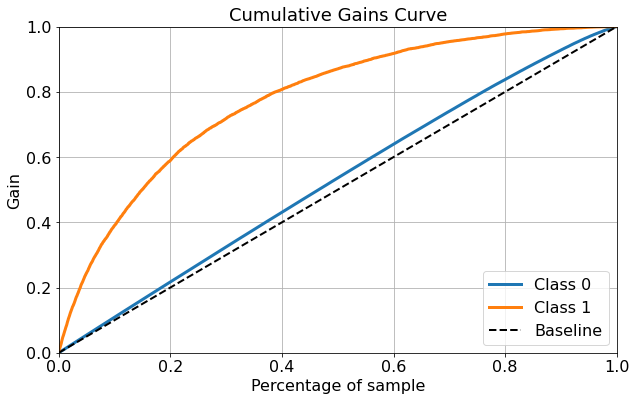

Lift Chart


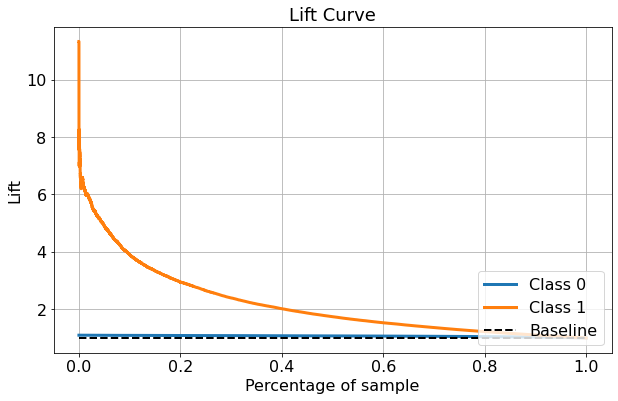



TEST RESULTS:

Accuracy Score: 0.78 

Confusion Matrix:
        pred:0  pred:1
true:0   26981    7230
true:1    1164    2036 

False Positive Rate: 0.21
True Positive Rate: 0.64
AUC: 0.71 

Sensitivity: 0.64
Specificity: 0.79 

F1 Score: 0.33 

KS Score:
KstestResult(statistic=0.1621448237149502, pvalue=0.0) 

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.79      0.87     34211
           1       0.22      0.64      0.33      3200

    accuracy                           0.78     37411
   macro avg       0.59      0.71      0.60     37411
weighted avg       0.90      0.78      0.82     37411

Gain Chart


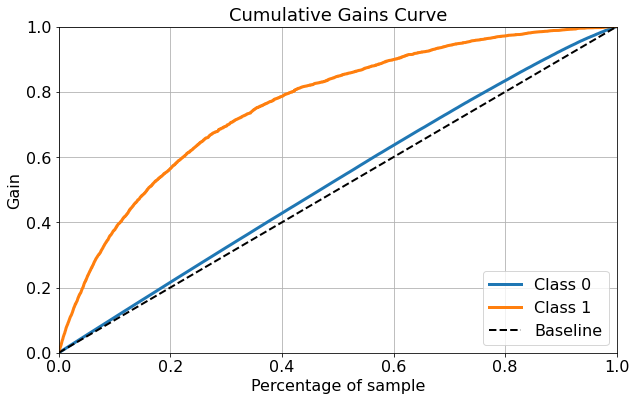

Lift Chart


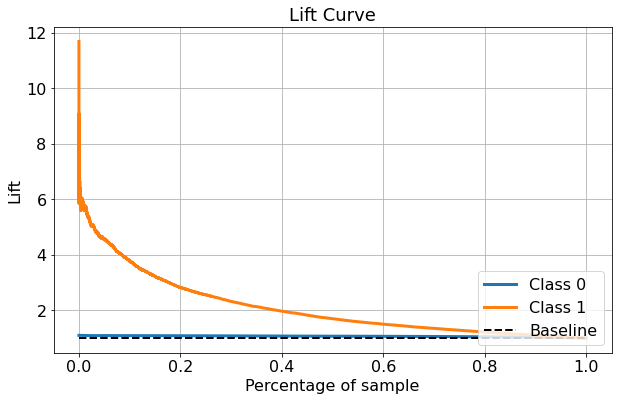



OOT RESULTS:

Accuracy Score: 0.8 

Confusion Matrix:
        pred:0  pred:1
true:0   19208    4429
true:1     621    1116 

False Positive Rate: 0.19
True Positive Rate: 0.64
AUC: 0.73 

Sensitivity: 0.64
Specificity: 0.81 

F1 Score: 0.31 

KS Score:
KstestResult(statistic=0.15007487979821865, pvalue=6.478357591247889e-250) 

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.81      0.88     23637
           1       0.20      0.64      0.31      1737

    accuracy                           0.80     25374
   macro avg       0.58      0.73      0.60     25374
weighted avg       0.92      0.80      0.84     25374

Gain Chart


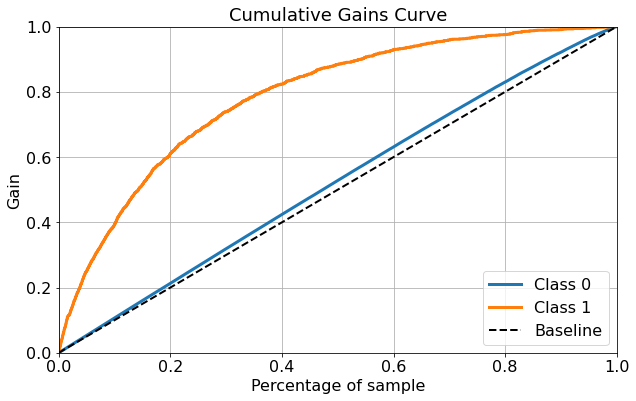

Lift Chart


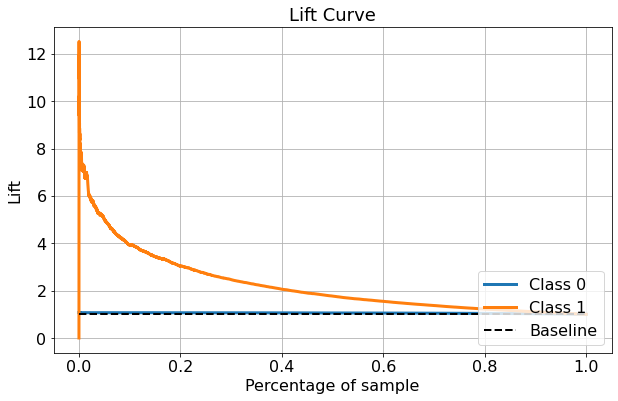

In [102]:
# Depth:3 and Weight:8
x_tr = x_train[top30_features]
x_te = x_test[top30_features]
x_oo = x_oot[top30_features]


tuned_model6 = XGBClassifier(random_state=3, max_depth=3, scale_pos_weight=8, learning_rate=0.1, eval_metric='logloss')
tuned_model6.fit(x_tr, y_train)

###################################
depth = 3
weight = 8
file_name = 'nsql_model_depth_'+str(depth)+'_weight_'+str(weight)+'.pkl'
path = project_path + 'models_tmp2/'
pickle.dump(tuned_model6, open(path + file_name, "wb"))
###################################

# Prediction on the train, test & oot datasets
print("TRAIN RESULTS:\n")
y_pred = tuned_model6.predict(x_tr)
predicted_probas = tuned_model6.predict_proba(x_tr)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = tuned_model6.predict(x_te)
predicted_probas = tuned_model6.predict_proba(x_te)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = tuned_model6.predict(x_oo)
predicted_probas = tuned_model6.predict_proba(x_oo)
model_metrics(y_pred, y_oot, predicted_probas)


In [103]:
top30_features

['estimated_monthly_revenue',
 'incoming_ach_payments',
 'sh_sw_ratio_mean',
 'screen_width_mean',
 'industry_category_name_professional, scientific, and technical services',
 'business_group',
 'outgoing_ach_and_checks',
 'socure_sigma',
 'iovation_device_type_mac',
 'industry_category_name_real estate rental and leasing',
 'socure_emailrisk',
 'socure_emailrisk_reason_code_i566',
 'socure_phonerisk',
 'industry_category_name_retail trade',
 'socure_emailrisk_reason_code_i553',
 'iovation_device_type_android',
 'outgoing_wire_transfers',
 'socure_emailrisk_reason_code_r561',
 'check_deposit_amount',
 'socure_phonerisk_reason_code_i630',
 'socure_reason_code_r207',
 'socure_phonerisk_reason_code_i614',
 'iovation_device_timezone_480',
 'industry_category_name_administrative and support and waste management and remediation services',
 'socure_phonerisk_reason_code_r616',
 'email_domain_bucket',
 'incoming_wire_transfer',
 'industry_category_name_health care and social assistance',
 'soc

### Conclusion:
- The model with depth 4 and class weight 6 is selected as the best model based on the Recall, Precision and AUC